## Linguistic and structural analysis

1. Preprocessing

Standard text preprocessing steps were applied to ensure data quality and consistency:

- Tokenization of titles
- Lowercasing of text
- Removal of stopwords, special characters, and non-informative tokens
- Deduplication of near-identical entries

NLP Techniques

1. **Part-of-Speech (POS) Tagging**  
   Identifies grammatical roles and recurring syntactic patterns.

1. **Dependency Parsing**  
   Examines how **gendered** and **racialized** terms are positioned within phrases, revealing structural relationships.

1. **Bigram and Trigram Modeling**  
   Captures frequently occurring word sequences and stereotypical expressions.


In [1]:
import pandas as pd
from collections import Counter
import src.models.embeddings as embeddings
import src.utils.helpers as helpers
import src.data.clean as clean

import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.WARNING)

/home/olga/Documents/eur-porntypes/stereotype-map/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Curated list of nouns and adjectives


In [2]:
from typing import Set

SMALL_ADJECTIVES: Set[str] = {
    "small",
    "tiny",
    "petite",
    "little",
    "slim",
    "narrow",
    "tight",
    "skinny",
    "mini",
    "wee",
    "diminutive",
    "compact",
    "slender",
    "short",
}
LARGE_ADJECTIVES: Set[str] = {
    "big",
    "large",
    "huge",
    "giant",
    "massive",
    "thick",
    "broad",
    "wide",
    "enormous",
    "colossal",
    "immense",
    "vast",
    "tall",
    "long",
}

FEMALE_NOUNS: Set[str] = {
    "girl",
    "tit",
    "boob",
    "babe",
    "pussi",
    "blondwoman",
    "wife",
    "mom",
    "stepmom",
    "lady",
    "female",
    "daughter",
    "sister",
    "mother",
    "girlfriend",
    "teen",
    "housewife",
    "bride",
    "mistress",
    "goddess",
    "queen",
    "princess",
    "she",
    "slut",
    "whore",
    "chick",
    "stepsister",
    "bitch",
    "women",
    "breast",
    "redhead",
    "schoolgirl",
    "milf",
    "mistress",
    "cheerleader",
    "cunt",
    "brunette",
    "stepsister",
}

MALE_NOUNS: Set[str] = {
    "boy",
    "cock",
    "dick",
    "men",
    "daddi",
    "man",
    "pole",
    "wood",
    "twink",
    "jock",
    "hunk",
    "bf",
    "stag",
    "stallion",
    "husband",
    "dad",
    "guy",
    "male",
    "brother",
    "son",
    "dude",
    "boyfriend",
    "groom",
    "prince",
    "king",
    "stud",
    "gentleman",
    "hero",
    "beast",
    "champion",
    "legend",
    "he",
    "stepdad",
    "stepbrother",
    "ex",
}

APPEARANCE_ADJECTIVES: Set[str] = {
    "hot",
    "sexy",
    "cute",
    "beautiful",
    "blonde",
    "busty",
    "naughty",
    "attractive",
    "pretty",
    "gorgeous",
    "slim",
    "curvy",
    "slender",
}

ROLE_ACTION_ADJECTIVES: Set[str] = {
    "dominant",
    "experienced",
    "aggressive",
    "first",
    "young",
    "mature",
    "amateur",
    "professional",
    "hardcore",
    "wild",
}

PLACE_NOUNS: Set[str] = {
    "kitchen",
    "bathroom",
    "school",
    "hotel",
    "car",
    "office",
    "beach",
    "classroom",
    "park",
    "gym",
    "public",
    "bedroom",
    "club",
    "bus",
    "library",
    "shower",
}

RACIALIZED_TERMS: Set[str] = {
    "black",
    "asian",
    "eboni",
    "white",
    "latina",
    "german",
    "french",
    "russian",
    "spanish",
    "italian",
    "indian",
    "dark",
    "british",
    "brazilian",
    "korean",
    "european",
    "brown",
    "thai",
    "african",
    "orient",
    "arab",
    "english",
    "muslim",
    "canadian",
    "hungarian",
}

STEREOTYPED_TERMS = {
    "body": {"tit", "boob", "pussy", "ass", "cock", "dick"},
    "age": {"teen", "mature", "young", "old"},
    "race": {
        "black",
        "asian",
        "eboni",
        "white",
        "latina",
        "german",
        "french",
        "russian",
        "spanish",
        "italian",
        "indian",
        "dark",
        "british",
        "brazilian",
        "korean",
        "european",
        "brown",
        "thai",
        "african",
        "orient",
        "arab",
        "english",
        "muslim",
        "canadian",
        "hungarian",
    },
    "role": {"slut", "milf", "stepmom", "stepson", "whore"},
}

BODY_NOUNS = [
    "cock",
    "pussy",
    "pussi",
    "breast",
    "tit",
    "tits",
    "boob",
    "boobs",
    "dick",
    "ass",
    "penis",
    "vagina",
    "hole",
    "balls",
    "body",
]

YOUTH_ADJECTIVES: Set[str] = {
    "young",
    "small",
    "slim",
    "slender",
    "babe",
    "chick",
    "girl",
    "youthful",
    "adolescent",
    "juvenile",
    "puber",
    "cuteteen",
    "fresh",
    "innocent",
    "naive",
    "cute",
    "petite",
    "tiny",
    "little",
    "nubile",
    "virgin",
    "new",
    "first",
    "curious",
    "barely",  # as in "barely legal"
    "legal",  # as in "barely legal"
    "schoolgirl",
    "school",
    "college",
    "junior",
    "babysitter",
    "cheerleader",
    "student",
    "girlish",
    "undergrad",
    "tender",
    "delicate",
    "blossoming",
    "innocent",
    "naive",
}


MATURE_ADJECTIVES: Set[str] = {
    "mature",
    "older",
    "oldexperienced",
    "seasoned",
    "aged",
    "midlife",
    "middle-aged",
    "senior",
    "veteran",
    "grown",
    "established",
    "daddy",
    "dad",
    "father",
    "stepdad",
    "husband",
    "boss",
    "professor",
    "principal",
    "coach",
    "doctor",
    "executive",
    "businessman",
    "professional",
    "teacher",
    "instructor",
    "trainer",
    "mentor",
    "dominant",
    "master",
    "guy",
    "dude",
}

ASIAN_ADJECTIVES = {"asian", "japanese", "chinese", "korean", "thai", "filipina"}
BLACK_ADJECTIVES = {"black", "ebony", "african", "afro", "dark", "brown", "eboni"}
WHITE_ADJECTIVES = {
    "white",
    "blonde",
    "caucasian",
    "european",
    "canadian",
    "british",
    "english",
    "hungarian",
    "german",
    "french",
    "russian",
    "spanish",
    "italian",
}
LATINA_ADJECTIVES = {"latina", "mexican", "brazilian", "colombian"}
MUSLIM_ADJECTIVES = {"muslim", "arab", "turkish", "indian", "pakistani", "persian"}

#### Load pornhub dataset


In [3]:
columns_to_read = ["url", "title", "categories", "date", "views", "upvotes"]

df = pd.read_csv("data/raw/data2008-2024.csv", usecols=columns_to_read)
df.tail(25)

,url,title,categories,date,views,upvotes
256101,https://www.pornhub.com/view_video.php?viewkey...,BANGBROS - Brother Goes Deep in Step Sister Aa...,"['Anal', 'Babe', 'Big Ass', 'Big Tits', 'HD Po...",2017-10-18,NaN,NaN
256102,https://www.pornhub.com/view_video.php?viewkey...,Ele queria jogar video game e eu queria dar o ...,"['Amateur', 'Anal', 'Big Ass', 'Brazilian', 'H...",2024-07-14,NaN,NaN
256103,https://www.pornhub.com/view_video.php?viewkey...,Throat dragon Latina gets pounded by BWC,"['18-25', 'Big Ass', 'Big Dick', 'Blowjob', 'C...",2023-01-27,NaN,NaN
256104,https://www.pornhub.com/view_video.php?viewkey...,busty horny mom,"['Big Tits', 'MILF', 'Mature']",2012-07-06,NaN,NaN
256105,https://www.pornhub.com/view_video.php?viewkey...,Fingering my wet pussy in leather mini skirt a...,"['18-25', 'Big Tits', 'Brunette', 'Exclusive',...",2020-10-17,NaN,NaN
256106,https://www.pornhub.com/view_video.php?viewkey...,DOEGIRLS - Sexy Big Tits Blonde Kaisa Nord Rid...,"['Babe', 'Big Ass', 'Big Tits', 'Female Orgasm...",2022-08-20,NaN,NaN
256107,https://www.pornhub.com/view_video.php?viewkey...,Boyfriends Bareback Cum Compilation - Vol 1,"['Amateur', 'Bareback', 'Big Dick', 'Compilati...",2021-06-05,NaN,NaN
256108,https://www.pornhub.com/view_video.php?viewkey...,【盗撮】貧乳女子にバレないように隠し撮りする Japanese,"['Amateur', 'Babe', 'Blowjob', 'Exclusive', 'H...",2022-01-15,NaN,NaN
256109,https://www.pornhub.com/view_video.php?viewkey...,Giochi di specchi - Da sola a casa mi masturbo...,"['Amateur', 'Big Ass', 'Female Orgasm', 'HD Po...",2021-06-12,5400.0,46.0
256110,https://www.pornhub.com/view_video.php?viewkey...,Busty MILF Brought Home Mistress to Play,"['Babe', 'Big Ass', 'Big Tits', 'FFM in Threes...",2020-03-22,NaN,NaN


In [4]:
import os

plot_output_path = "plots"
data_output_path = "data/processed"

os.makedirs(plot_output_path, exist_ok=True)  # ensure the folder exists
os.makedirs(data_output_path, exist_ok=True)

%load_ext autoreload
%autoreload 2


In [5]:
pd.to_datetime(df.date).max()


Timestamp('2024-08-08 00:00:00')

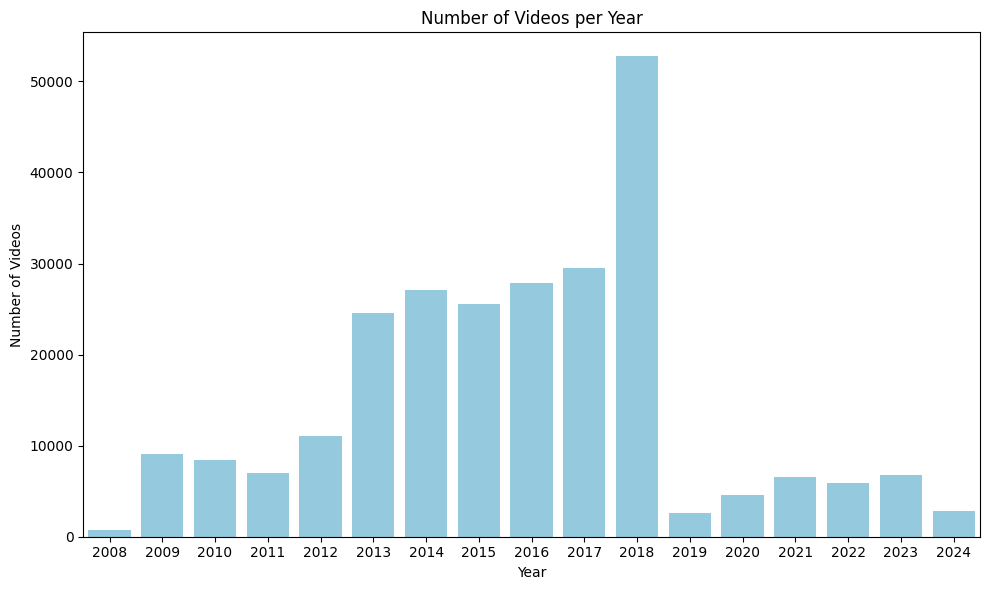

In [6]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

videos_per_year = df["year"].value_counts().sort_index()

# Plot number of videos per year
plt.figure(figsize=(10, 6))
sns.barplot(
    x=videos_per_year.index.astype(int), y=videos_per_year.values, color="skyblue"
)
plt.xlabel("Year")
plt.ylabel("Number of Videos")
plt.title("Number of Videos per Year")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path, "videos_per_year.png"), bbox_inches="tight")
plt.show()

In [7]:
# Statistics on the counts (number of videos per year)
mean_count = videos_per_year.mean()
std_count = videos_per_year.std()
min_count = videos_per_year.min()
max_count = videos_per_year.max()

print(f"Minimum videos in a year: {min_count}")
print(f"Maximum videos in a year: {max_count}")
print(f"Mean videos per year: {mean_count:.2f}")
print(f"Standard deviation of videos per year: {std_count:.2f}")

Minimum videos in a year: 763
Maximum videos in a year: 52746
Mean videos per year: 14881.35
Standard deviation of videos per year: 14023.94


#### Adjective noun pairs in titles


In [8]:
# Calculate title lengths
df["title_length"] = df["title"].astype(str).apply(len)

# Get statistics
mean_length = df["title_length"].mean()
median_length = df["title_length"].median()
std_length = df["title_length"].std()
min_length = df["title_length"].min()
max_length = df["title_length"].max()

print(f"Mean title length: {mean_length:.2f}")
print(f"Median title length: {median_length}")
print(f"Standard deviation: {std_length:.2f}")
print(f"Min title length: {min_length}")
print(f"Max title length: {max_length}")

Mean title length: 40.78
Median title length: 39.0
Standard deviation: 17.54
Min title length: 1
Max title length: 102


In [9]:
from src.models import embeddings

embeddings.download_nltk_data()

# Ensure all titles are strings and fill NaN with empty string
df["title"] = df["title"].fillna("").astype(str)

# Apply the function to the title column
df["title_words"] = df["title"].apply(embeddings.clean_tokenize_and_stem)

# Flatten the list of words and count frequencies
all_words = [word for words in df["title_words"] for word in words]
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(most_common_words, columns=["word", "count"])


[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df.title_words

0                           [cute, teen, gloryhol, handjob]
1         [reali, nice, step, mom, angi, give, titjob, g...
2                               [step, mom, gift, son, pov]
3                       [baltimor, street, hooker, creampi]
4                           [cute, blond, brunett, pleasur]
                                ...                        
256121                                      [video, disabl]
256122                                      [famou, youtub]
256123                              [finger, squirt, pussi]
256124    [esposa, le, entrega, el, culo, su, vecino, lo...
256125                 [mädchen, masturbiert, im, solarium]
Name: title_words, Length: 256126, dtype: object

In [11]:
df["title"]

0                               Cute teen gloryhole handjob
1         Realy Nice Step Mom Angie Gives Titjob Good Yo...
2                             Step Mom´s gift for son - pov
3                          Baltimore Street Hooker Creampie
4              Cute Blonde and Brunette Pleasure Each Other
                                ...                        
256121                                       Video Disabled
256122                                of a famous YouTuber!
256123                        Fingering her squirting pussy
256124    Esposa le entrega el culo a su vecino y lo gra...
256125                      MÄDCHEN MASTURBIERT IM SOLARIUM
Name: title, Length: 256126, dtype: object

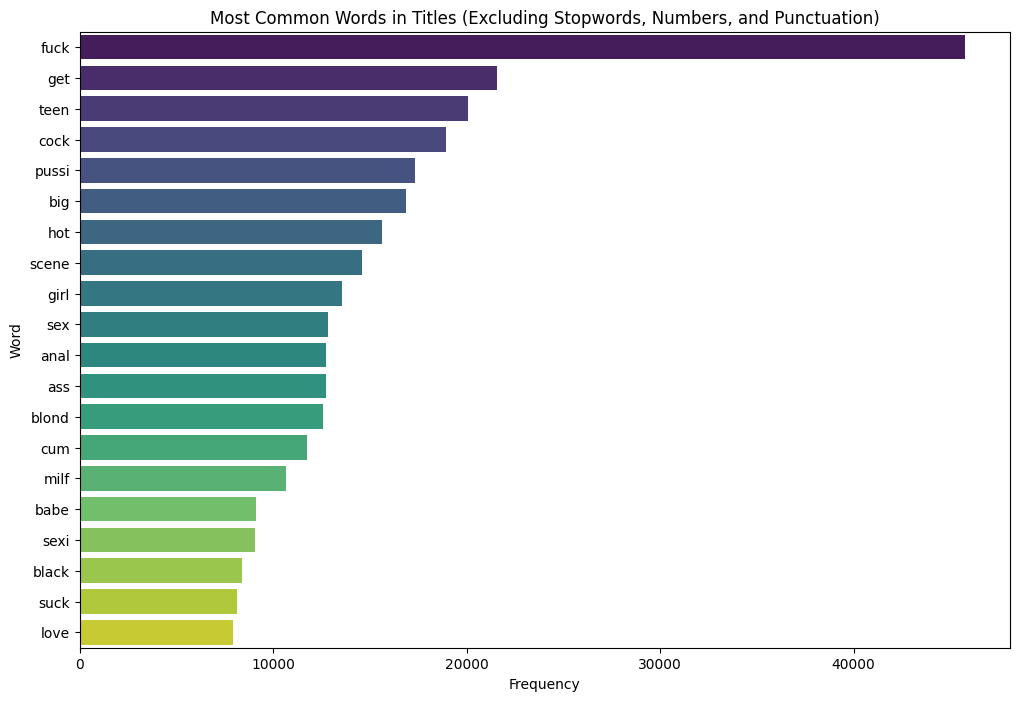

In [12]:
# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="word", data=word_freq_df, hue="word", palette="viridis")
plt.title("Most Common Words in Titles (Excluding Stopwords, Numbers, and Punctuation)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.savefig(
    os.path.join(plot_output_path, "words_titles_frequency_distribution.eps"),
    bbox_inches="tight",
)
plt.show()

### POS tagging


In [13]:
from src.models.extract_adj_noun_pairs import run_pipeline

# Run pipeline and keep everything
df, pair_df = run_pipeline(
    df,
    cache_filename="pos_title_with_deps.pkl",
    output_csv="adjective_noun_pairs.csv",
    return_pair_df=True,
    data_output_path="data/processed",
)


Loading cached POS data...
Saved 30493 adjective–noun pairs to data/processed/adjective_noun_pairs.csv


In [14]:
df.iloc[362].pos_title_with_deps

[('sell', 'VERB', 'ROOT'),
 ('gf', 'PROPN', 'compound'),
 ('limonika', 'NOUN', 'dobj'),
 ('sell', 'VERB', 'dep'),
 ('gf', 'NOUN', 'dobj'),
 ('cuz', 'SCONJ', 'mark'),
 ('want', 'NOUN', 'advcl')]

Select titles for accuracy analysis. A sample of 500 titles is selected randomply for manual tagging and validation of POS tagging accuracy. Additionally 10 are given with POS tags as an example.


In [15]:
# df[["title","pos_title_with_deps"]].sample(10).to_csv("data/processed/title_pos_sample_10.csv", index=True)
# df[["title", "pos_title_with_deps"]].sample(500).to_csv(
#     "data/processed/title_pos_sample_500.csv", index=True
# )

# title_pos_sample_500 =  pd.read_csv("data/processed/title_pos_sample_500.csv", index_col=0)

# # Step 1: split title into words
# word_cols = title_pos_sample_500["title"].str.split(expand=True)

# # Step 2: rename word columns (optional)
# word_cols.columns = [f"word_{i + 1}" for i in range(word_cols.shape[1])]

# # Step 3: combine with the first two original columns
# result = pd.concat([title_pos_sample_500.iloc[:, :2], word_cols], axis=1)
# result.to_csv("data/processed/title_pos_sample_500_expanded.csv", index=True)


##### What are the most common adjective–noun pairings in titles?


/tmp/ipykernel_80389/2103876292.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs, y="pair_str", x="Count", palette="viridis")


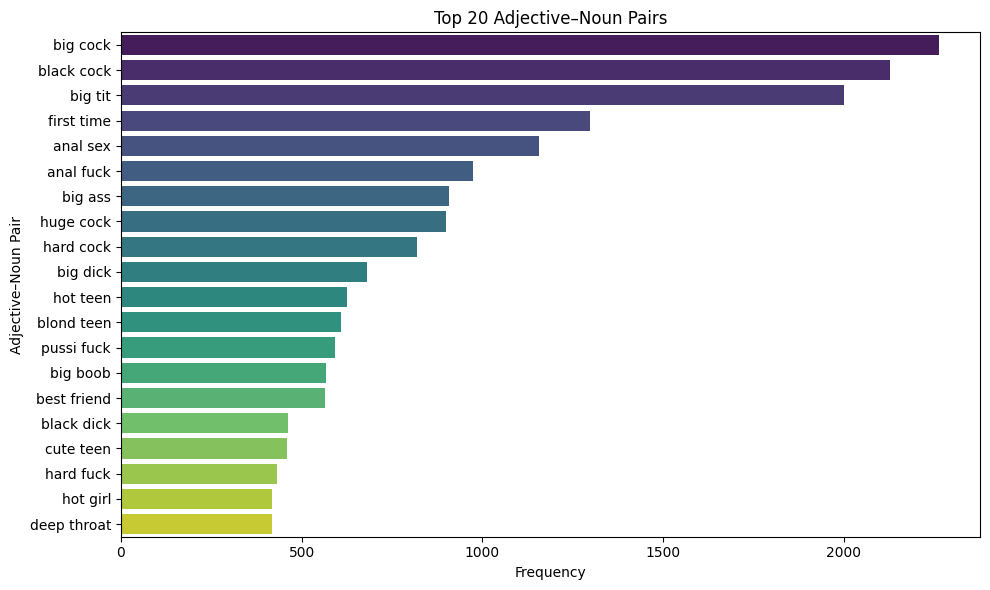

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top N pairs
top_n = 20
top_pairs = pair_df.head(top_n).copy()
top_pairs["pair_str"] = top_pairs["Pair"].apply(lambda x: f"{x[0]} {x[1]}")

plt.figure(figsize=(10, 6))
sns.barplot(data=top_pairs, y="pair_str", x="Count", palette="viridis")
plt.title(f"Top {top_n} Adjective–Noun Pairs")
plt.xlabel("Frequency")
plt.ylabel("Adjective–Noun Pair")
plt.tight_layout()
plt.savefig(
    os.path.join(plot_output_path, "adjective-noun-pair.eps"), bbox_inches="tight"
)
plt.show()


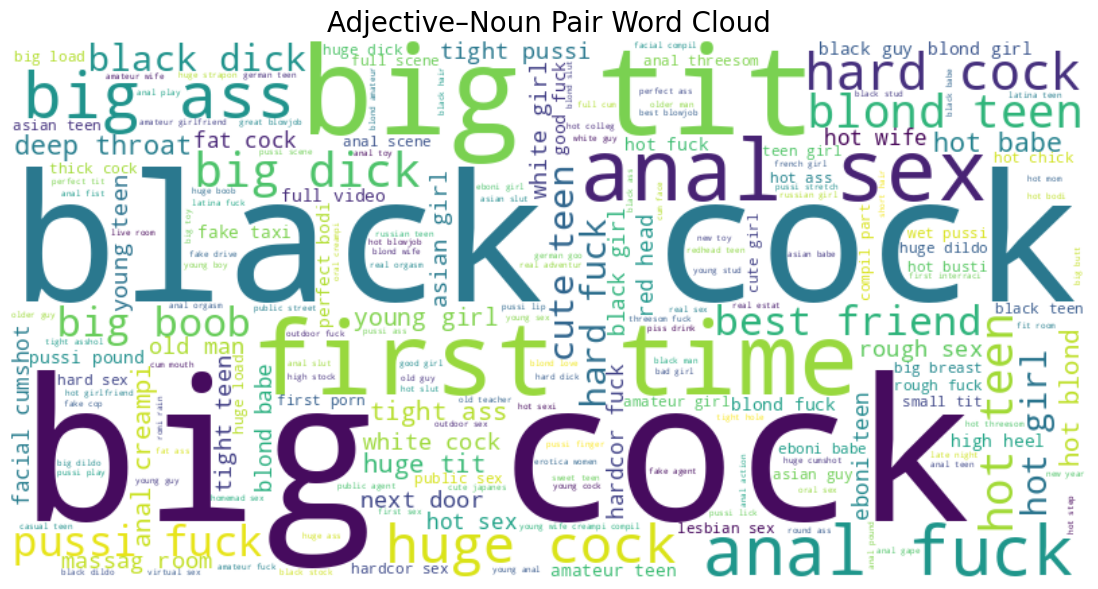

In [17]:
from wordcloud import WordCloud

# Prepare data for word cloud
pair_freq_dict = {
    f"{adj} {noun}": count for (adj, noun), count in pair_df.head(1000).values
}

wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(pair_freq_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Adjective–Noun Pair Word Cloud", fontsize=20)
plt.savefig(
    os.path.join(plot_output_path, "adj-noun-pair-word-cloud.eps"), bbox_inches="tight"
)
plt.savefig(
    os.path.join(plot_output_path, "adj-noun-pair-word-cloud.png"), bbox_inches="tight"
)
plt.show()


In [18]:
# Different ways to say pussy..using levenshtein distance

import difflib
from collections import Counter

# Flatten all words from title_words
all_words = [word for words in df["title_words"] for word in words]

# Get unique words to speed up matching
unique_words = set(all_words)

# Find words with high similarity to "pussy"
matches = [
    w for w in unique_words if difflib.SequenceMatcher(None, w, "pussy").ratio() > 0.7
]

# Count their frequencies in the corpus
fuzzy_counts = Counter([w for w in all_words if w in matches])

# Show the most common fuzzy matches
print(fuzzy_counts.most_common(20))

[('pussi', 17338), ('pussylick', 76), ('puss', 62), ('pussyfuck', 26), ('pussyrub', 11), ('pussycat', 11), ('pusssi', 11), ('pussyjob', 9), ('pussyeat', 9), ('pussyman', 7), ('pussykat', 6), ('pussylov', 5), ('pussy_ful', 3), ('pussypov', 2), ('pussysh', 2), ('pussynail', 2), ('pussylici', 2), ('pussyy', 2), ('pussyplay', 2), ('pussylip', 2)]


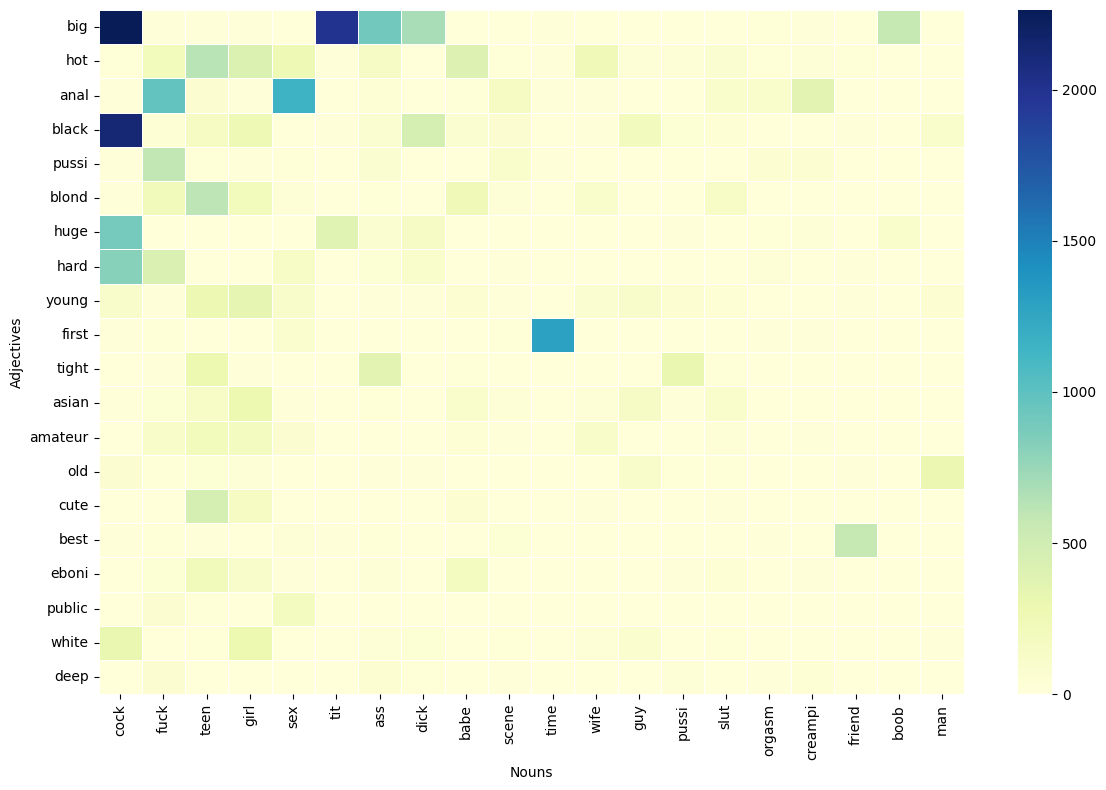

In [19]:
# Create a DataFrame for heatmap: rows = adjectives, cols = nouns

heat_df = pair_df.copy()
heat_df["Adjective"] = heat_df["Pair"].apply(lambda x: x[0])
heat_df["Noun"] = heat_df["Pair"].apply(lambda x: x[1])

pivot = heat_df.pivot_table(
    index="Adjective", columns="Noun", values="Count", fill_value=0
)
pivot_top = pivot.loc[
    pivot.sum(axis=1).sort_values(ascending=False).head(20).index,  # top 20 adjectives
    pivot.sum().sort_values(ascending=False).head(20).index,
]  # top 20 nouns

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_top, cmap="YlGnBu", linewidths=0.5)
plt.xlabel("Nouns")
plt.ylabel("Adjectives")
plt.tight_layout()
plt.savefig(
    os.path.join(plot_output_path, "heatmap-adj-noun-pair.eps"), bbox_inches="tight"
)
plt.savefig(
    os.path.join(plot_output_path, "heatmap-adj-noun-pair.png"), bbox_inches="tight"
)
plt.show()


In [20]:
# Save the DataFrame with adjective-noun pairs to a CSV file
adjective_noun_df = pd.DataFrame(
    pair_df["Pair"].tolist(), columns=["Adjective", "Noun"]
)
adjective_noun_df["Count"] = pair_df["Count"].values
adjective_noun_df.to_csv("data/processed/adjective_noun_pairs_split.csv", index=False)

# Count total occurrences of each noun in adjective–noun pairs
noun_counts = (
    adjective_noun_df.groupby("Noun")["Count"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
noun_counts.columns = ["Noun", "Total_Count"]
noun_counts.to_csv("data/processed/noun_counts.csv", index=False)

# Count total occurrences of each adjective in adjective–noun pairs

adjective_counts = (
    adjective_noun_df.groupby("Adjective")["Count"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
adjective_counts.columns = ["Adjective", "Total_Count"]
adjective_counts.to_csv("data/processed/adjective_counts.csv", index=False)

adjective_counts


,Adjective,Total_Count
0,big,8007
1,hot,7159
2,anal,6834
3,black,5921
4,pussi,3723
...,...,...
3647,日目人妻がライブチャットしてたら連続潮吹きイキすぎて気持ちよかった個人撮影live,1
3648,平台约的妹子,1
3649,小鸟酱写頁,1
3650,女子大生tバックのみでm字オナニーfemal,1


##### Heatmap for selected nouns


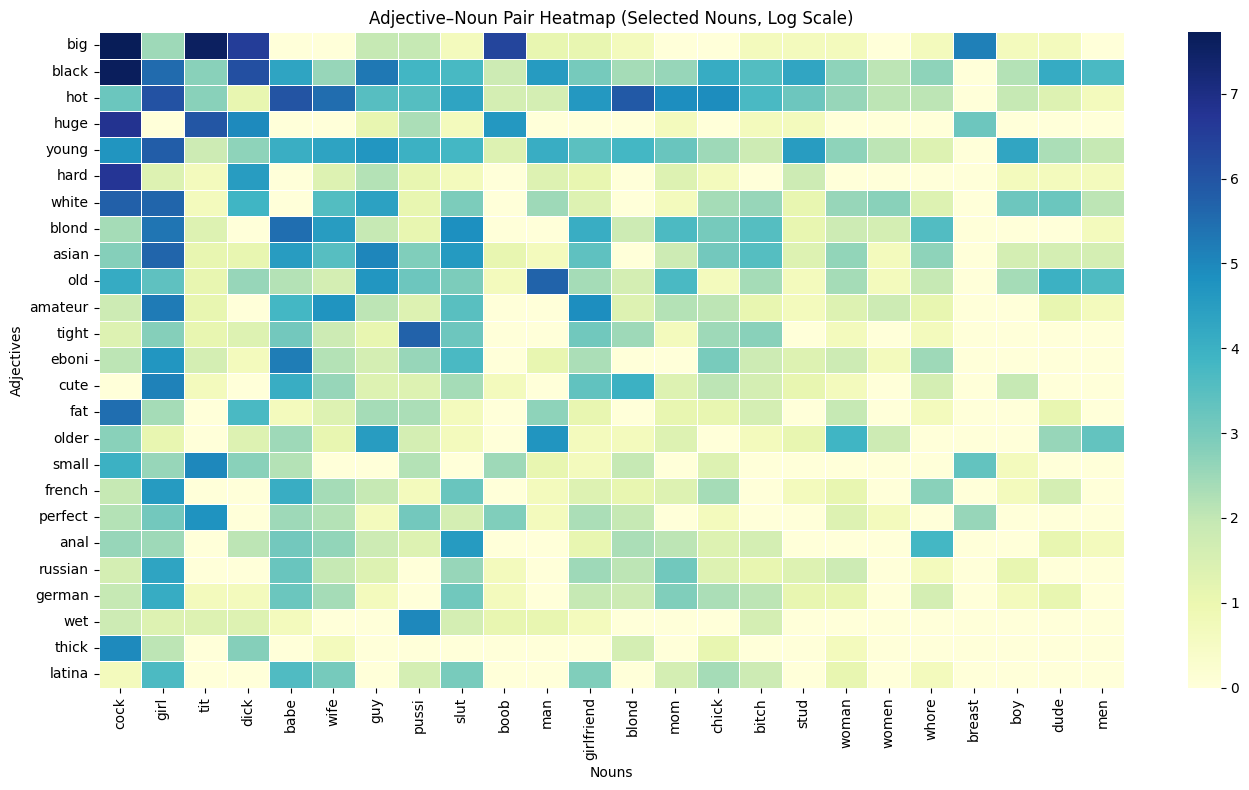

Log scale to original scale mapping (log1p):
log1p: 0.0 -> original: 0.0
log1p: 1.0 -> original: 1.7
log1p: 2.0 -> original: 6.4
log1p: 3.0 -> original: 19.1
log1p: 4.0 -> original: 53.6
log1p: 5.0 -> original: 147.4
log1p: 6.0 -> original: 402.4
log1p: 7.0 -> original: 1095.6


In [21]:
import numpy as np

# Heatmap for selected nouns (log scale)

selected_nouns = [
    "cock",
    "girl",
    "tit",
    "dick",
    "babe",
    "wife",
    "guy",
    "pussi",
    "slut",
    "boob",
    "man",
    "girlfriend",
    "blond",
    "mom",
    "chick",
    "bitch",
    "stud",
    "woman",
    "women",
    "whore",
    "breast",
    "readhead",
    "boy",
    "dude",
    "men",
]

heat_df = pair_df.copy()
heat_df["Adjective"] = heat_df["Pair"].apply(lambda x: x[0])
heat_df["Noun"] = heat_df["Pair"].apply(lambda x: x[1])

pivot = heat_df.pivot_table(
    index="Adjective", columns="Noun", values="Count", fill_value=0
)
present_nouns = [noun for noun in selected_nouns if noun in pivot.columns]
pivot_selected = pivot[present_nouns]

# Show only the top 25 adjectives (by total count across selected nouns)
top_n_adjs = 25
pivot_selected = pivot_selected.loc[
    pivot_selected.sum(axis=1).sort_values(ascending=False).head(top_n_adjs).index
]

# Apply log1p (log(1+x)) to avoid log(0)
pivot_log = np.log1p(pivot_selected)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_log, cmap="YlGnBu", linewidths=0.5)
plt.xlabel("Nouns")
plt.ylabel("Adjectives")
plt.title("Adjective–Noun Pair Heatmap (Selected Nouns, Log Scale)")
plt.tight_layout()
plt.savefig(
    os.path.join(plot_output_path, "heatmap_selected_nouns_log.png"),
    bbox_inches="tight",
)
plt.show()

# Conversion from log scale (0 to 7) back to original scale
log_values = np.arange(0, 7.1, 1)  # 0, 1, ..., 7
original_values = np.expm1(log_values)
print("Log scale to original scale mapping (log1p):")
for log_v, orig_v in zip(log_values, original_values):
    print(f"log1p: {log_v:.1f} -> original: {orig_v:.1f}")

##### Heatmap for selected adjectives


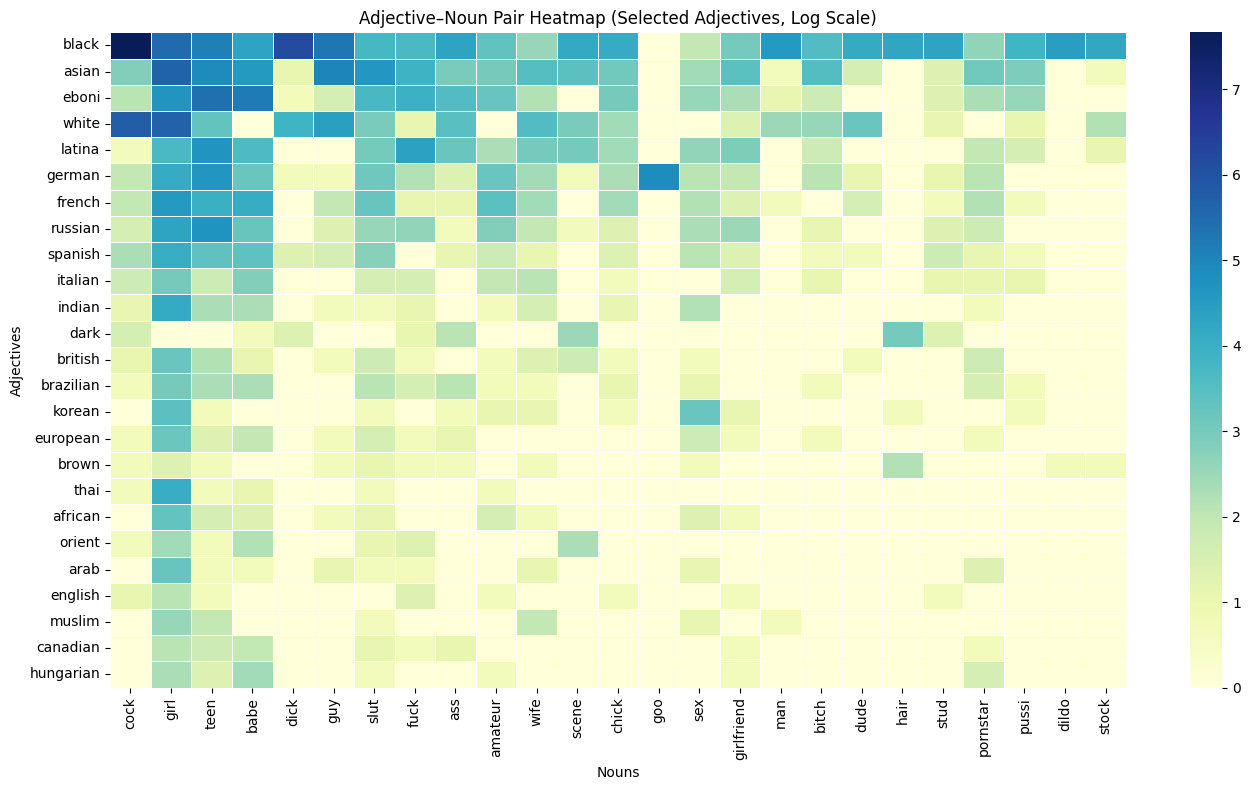

Log scale to original scale mapping (log1p):
log1p: 0.0 -> original: 0.0
log1p: 1.0 -> original: 1.7
log1p: 2.0 -> original: 6.4
log1p: 3.0 -> original: 19.1
log1p: 4.0 -> original: 53.6
log1p: 5.0 -> original: 147.4
log1p: 6.0 -> original: 402.4
log1p: 7.0 -> original: 1095.6


In [22]:
import numpy as np

selected_adjectives = [
    "black",
    "asian",
    "eboni",
    "white",
    "latina",
    "german",
    "french",
    "russian",
    "spanish",
    "italian",
    "indian",
    "dark",
    "british",
    "brazilian",
    "korean",
    "european",
    "brown",
    "thai",
    "african",
    "orient",
    "arab",
    "english",
    "muslim",
    "canadian",
    "hungarian",
]

# Prepare the heatmap DataFrame
heat_df = pair_df.copy()
heat_df["Adjective"] = heat_df["Pair"].apply(lambda x: x[0])
heat_df["Noun"] = heat_df["Pair"].apply(lambda x: x[1])

pivot = heat_df.pivot_table(
    index="Adjective", columns="Noun", values="Count", fill_value=0
)
present_adjs = [adj for adj in selected_adjectives if adj in pivot.index]
pivot_selected = pivot.loc[present_adjs]

# Optionally, show only the top N nouns (by total count across selected adjectives)
top_n_nouns = 25
pivot_selected = pivot_selected.loc[
    :, pivot_selected.sum(axis=0).sort_values(ascending=False).head(top_n_nouns).index
]

# Apply log1p (log(1+x)) to avoid log(0)
pivot_log = np.log1p(pivot_selected)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_log, cmap="YlGnBu", linewidths=0.5)
plt.xlabel("Nouns")
plt.ylabel("Adjectives")
plt.title("Adjective–Noun Pair Heatmap (Selected Adjectives, Log Scale)")
plt.tight_layout()
plt.savefig(
    os.path.join(plot_output_path, "heatmap_selected_adjectives_log.png"),
    bbox_inches="tight",
)
plt.show()

# Conversion from log scale (0 to 7) back to original scale
log_values = np.arange(0, 7.1, 1)  # 0, 1, ..., 7
original_values = np.expm1(log_values)
print("Log scale to original scale mapping (log1p):")
for log_v, orig_v in zip(log_values, original_values):
    print(f"log1p: {log_v:.1f} -> original: {orig_v:.1f}")

### Network analysis of adjective-noun pairs


#### Top Male and Female adjective-noun networks


In [23]:
pair_df

,Pair,Count
75,"(big, cock)",2263
107,"(black, cock)",2128
28,"(big, tit)",1999
37,"(first, time)",1298
281,"(anal, sex)",1156
...,...,...
14828,"(school_ful, movi)",1
14824,"(offic, upskirt)",1
14822,"(asian, date)",1
14791,"(bionic, woman)",1


In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os


def plot_adj_noun_graph(
    pair_df,
    noun_list,
    top_nouns=20,
    top_k_adjs_per_noun=5,
    output_file=None,
    seed=42,
):
    """
    Plot a bipartite graph of adjective–noun pairings and print centrality stats.

    Parameters:
    - pair_df: DataFrame with columns ["Pair", "Count"]
    - noun_list: List or set of nouns to filter
    - top_nouns: Number of top nouns to visualize (by total pair frequency)
    - top_k_adjs_per_noun: Number of top adjectives to keep per noun
    - output_file: If provided, saves plot to this path
    - seed: Random seed for layout
    """

    # Unpack pairs into separate columns
    df = pair_df.copy()
    df[["adjective", "noun"]] = df["Pair"].apply(pd.Series)

    # Filter to noun subset (e.g., FEMALE_NOUNS or MALE_NOUNS)
    df = df[df["noun"].isin(noun_list)]

    # Keep only top-k adjectives per noun
    df = (
        df.sort_values("Count", ascending=False)
        .groupby("noun")
        .head(top_k_adjs_per_noun)
        .reset_index(drop=True)
    )

    # Select top N most frequent nouns overall
    top_noun_counts = (
        df.groupby("noun")["Count"]
        .sum()
        .sort_values(ascending=False)
        .head(top_nouns)
        .index
    )
    min_count = 50

    top_pairs = df[df["noun"].isin(top_noun_counts)]

    # --- Build Graph ---
    G = nx.Graph()

    # Add noun nodes
    for noun in top_pairs["noun"].unique():
        G.add_node(noun, type="noun", color="lightblue", size=1000)

    # Add adjective nodes with size scaled by total usage
    adj_counts = top_pairs.groupby("adjective")["Count"].sum().to_dict()
    for adj, count in adj_counts.items():
        size = np.log1p(count) * 150
        G.add_node(adj, type="adj", color="lightcoral", size=size)

    # Add edges (unweighted visually, but store weight for analysis)
    for _, row in top_pairs.iterrows():
        G.add_edge(row["adjective"], row["noun"], weight=row["Count"])

    # --- Centrality Analysis ---
    deg_cent = nx.degree_centrality(G)
    weighted_deg = dict(G.degree(weight="weight"))

    print("\nTop Adjectives by Degree Centrality:")
    for node, centrality in sorted(deg_cent.items(), key=lambda x: -x[1]):
        if G.nodes[node]["type"] == "adj":
            print(f"{node}: {centrality:.3f}")

    print("\nTop Adjectives by Weighted Degree (Sum of Co-occurrence Counts):")
    for node, wdeg in sorted(weighted_deg.items(), key=lambda x: -x[1]):
        if G.nodes[node]["type"] == "adj":
            print(f"{node}: {wdeg}")

    # --- Draw Graph ---
    pos = nx.spring_layout(G, k=7, iterations=300, seed=seed)

    node_colors = [G.nodes[n]["color"] for n in G.nodes()]
    node_sizes = [G.nodes[n].get("size", 1000) for n in G.nodes()]

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, width=0.5, edge_color="gray")

    nx.draw_networkx_labels(
        G,
        pos,
        font_size=8,
        bbox=dict(
            facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2"
        ),
    )

    plt.axis("off")
    plt.tight_layout()

    if output_file:
        plt.savefig(
            os.path.join(plot_output_path, output_file),
            bbox_inches="tight",
        )
    plt.show()



Top Adjectives by Degree Centrality:
hot: 0.286
blond: 0.245
young: 0.224
asian: 0.163
black: 0.143
teen: 0.122
big: 0.082
amateur: 0.061
cute: 0.061
french: 0.061
huge: 0.061
perfect: 0.061
small: 0.061
tight: 0.061
white: 0.061
anal: 0.041
eboni: 0.041
german: 0.041
best: 0.020
erotica: 0.020
fake: 0.020
new: 0.020
nice: 0.020
old: 0.020
other: 0.020
pink: 0.020
porn: 0.020
russian: 0.020
taboo: 0.020
twin: 0.020
wet: 0.020

Top Adjectives by Weighted Degree (Sum of Co-occurrence Counts):
big: 2744
hot: 2379
teen: 2276
blond: 1290
young: 888
tight: 605
asian: 595
cute: 510
huge: 507
black: 448
white: 336
amateur: 259
eboni: 201
small: 183
perfect: 148
wet: 147
anal: 141
erotica: 111
pink: 64
other: 56
fake: 49
porn: 46
old: 40
french: 32
russian: 22
german: 18
nice: 13
twin: 11
new: 7
taboo: 6
best: 2


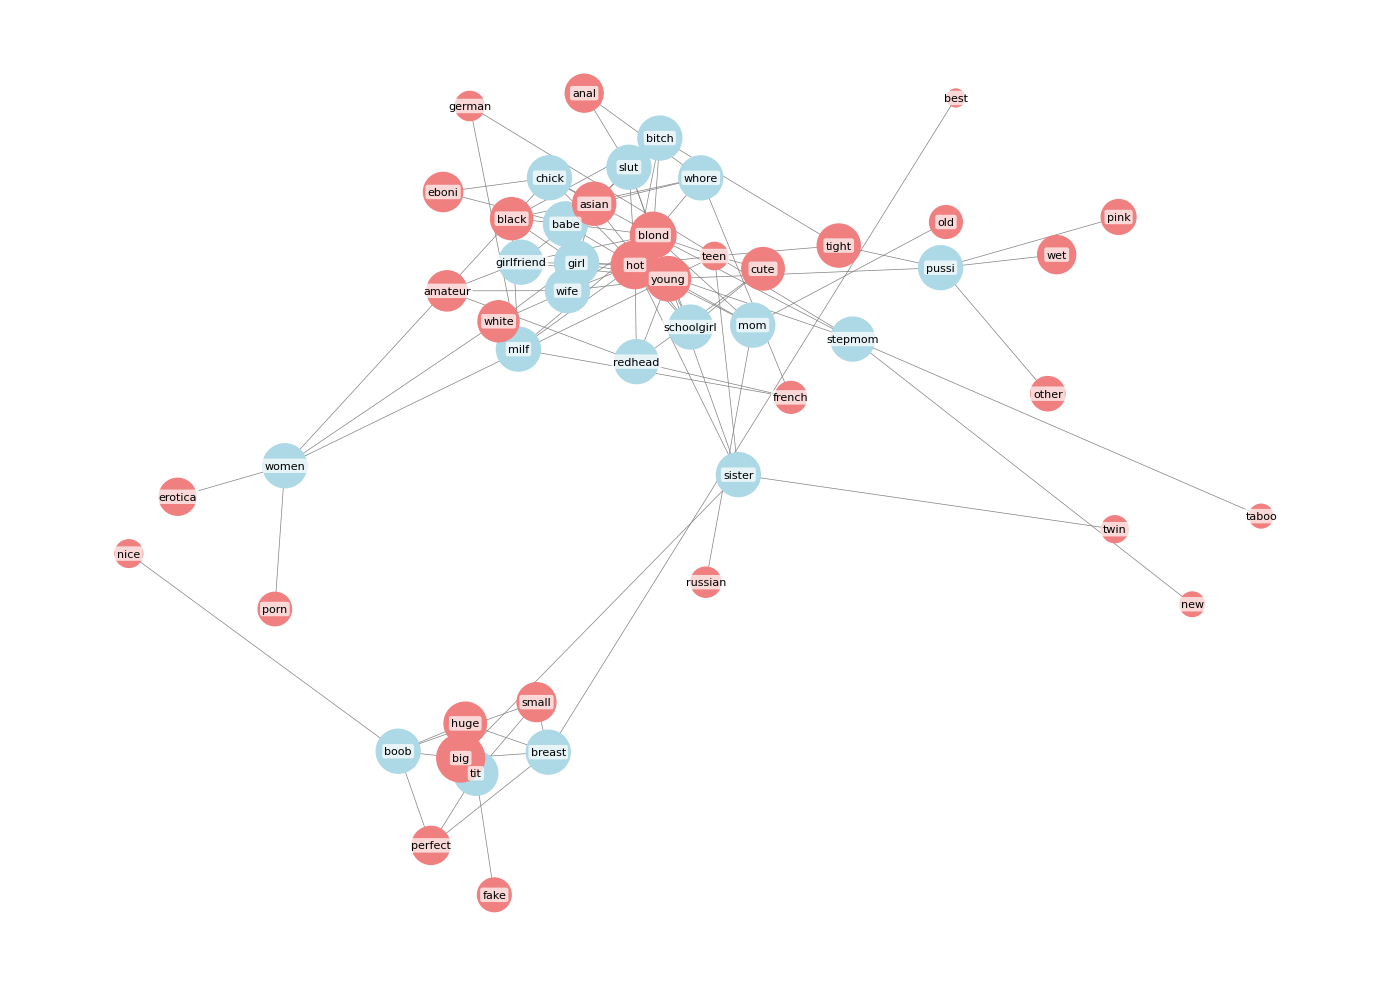


Top Adjectives by Degree Centrality:
black: 0.263
old: 0.140
young: 0.140
older: 0.105
white: 0.105
big: 0.088
hot: 0.088
hard: 0.070
muscular: 0.070
younger: 0.053
blond: 0.035
huge: 0.035
new: 0.035
real: 0.035
anal: 0.018
asian: 0.018
australian: 0.018
bad: 0.018
better: 0.018
classic: 0.018
creampi: 0.018
cuckold: 0.018
cum: 0.018
cute: 0.018
dutch: 0.018
enough: 0.018
facial: 0.018
front: 0.018
good: 0.018
kendal: 0.018
morn: 0.018
nake: 0.018
outdoor: 0.018
quick: 0.018
servic: 0.018
stripper: 0.018
threesom: 0.018
tight: 0.018

Top Adjectives by Weighted Degree (Sum of Co-occurrence Counts):
black: 3126
big: 2985
huge: 1044
hard: 925
old: 536
white: 418
young: 353
older: 255
asian: 150
front: 48
hot: 47
younger: 41
classic: 30
muscular: 27
new: 22
bad: 20
facial: 16
blond: 14
good: 12
cute: 11
real: 11
creampi: 10
cuckold: 9
morn: 9
kendal: 8
better: 6
stripper: 6
anal: 4
cum: 3
enough: 3
nake: 3
outdoor: 3
australian: 2
quick: 2
tight: 2
dutch: 1
servic: 1
threesom: 1


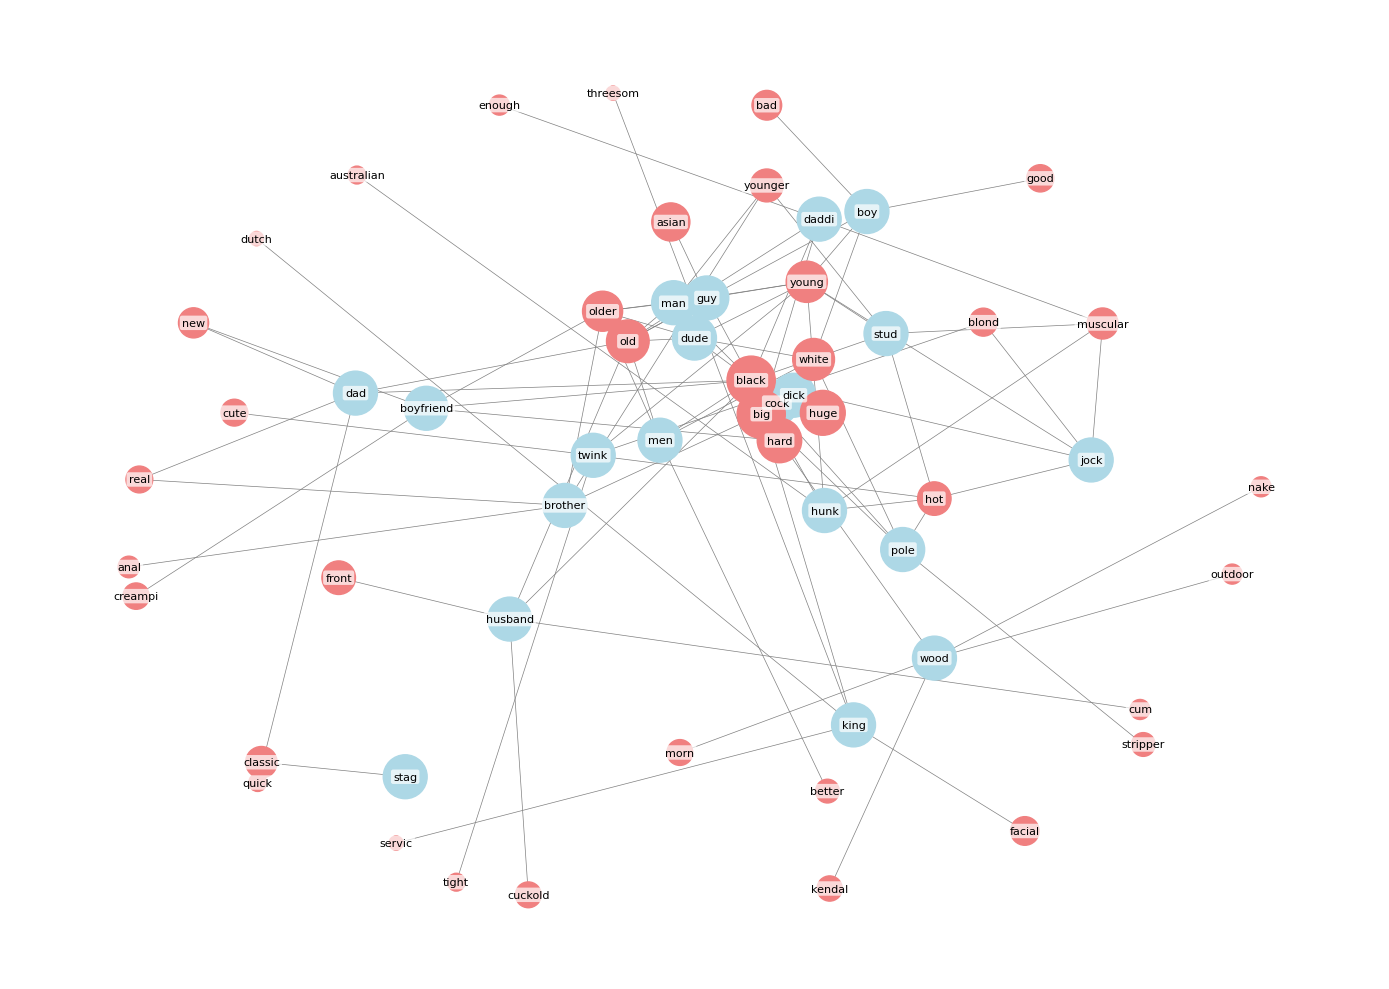

In [25]:
plot_adj_noun_graph(
    pair_df=pair_df,
    noun_list=FEMALE_NOUNS,
    top_nouns=20,
    top_k_adjs_per_noun=5,
    output_file="female-adj-noun-graph.png",
)
plot_adj_noun_graph(
    pair_df=pair_df,
    noun_list=MALE_NOUNS,
    top_nouns=20,
    top_k_adjs_per_noun=5,
    output_file="male-adj-noun-graph.png",
)


In [26]:
df.pos_title_with_deps


0         [(cute, ADJ, amod), (teen, NOUN, compound), (g...
1         [(reali, PROPN, amod), (nice, ADJ, amod), (ste...
2         [(step, NOUN, ROOT), (mom, NOUN, compound), (g...
3         [(baltimor, PROPN, compound), (street, PROPN, ...
4         [(cute, ADJ, amod), (blond, PROPN, compound), ...
                                ...                        
256121      [(video, NOUN, compound), (disabl, NOUN, ROOT)]
256122           [(famou, ADJ, amod), (youtub, NOUN, ROOT)]
256123    [(finger, NOUN, compound), (squirt, PROPN, com...
256124    [(esposa, PROPN, compound), (le, PROPN, compou...
256125    [(mädchen, ADV, advmod), (masturbiert, VERB, R...
Name: pos_title_with_deps, Length: 256126, dtype: object

In [27]:
# Extract data underliyng the graphs
import pandas as pd

# Unpack pairs into separate columns
dat = pair_df.copy()
dat[["adjective", "noun"]] = dat["Pair"].apply(pd.Series)


# Helper function to extract top 5 adjectives with counts per noun
def extract_top_adjectives(df_subset, noun_set):
    filtered = df_subset[df_subset["noun"].isin(noun_set)].copy()
    grouped = filtered.groupby(["noun", "adjective"])["Count"].sum().reset_index()

    results = []
    for noun in grouped["noun"].unique():
        sub_df = grouped[grouped["noun"] == noun]
        top5 = sub_df.sort_values("Count", ascending=False).head(5)
        adj_string = ", ".join(
            f"{adj} ({cnt})" for adj, cnt in zip(top5["adjective"], top5["Count"])
        )
        results.append({"noun": noun, "top_adjectives": adj_string})

    return pd.DataFrame(results).sort_values("noun").reset_index(drop=True)


# Female and Male tables
female_table = extract_top_adjectives(dat, FEMALE_NOUNS)
male_table = extract_top_adjectives(dat, MALE_NOUNS)

female_table.to_csv(
    os.path.join(data_output_path, "top_adjectives_female.csv"), index=False
)
male_table.to_csv(
    os.path.join(data_output_path, "top_adjectives_male.csv"), index=False
)


#### Top racialized adjectives that describe nouns


In [28]:
# extract data for racialized adjectives

import pandas as pd

# Unpack pair column into adjective and noun
dat = pair_df.copy()
dat[["adjective", "noun"]] = dat["Pair"].apply(pd.Series)

# Filter rows where adjective is in RACIALIZED_TERMS
racial_df = dat[dat["adjective"].isin(RACIALIZED_TERMS)].copy()

# Group by adjective and noun, summing counts
grouped_race = racial_df.groupby(["adjective", "noun"])["Count"].sum().reset_index()


# Extract top N nouns for each racialized adjective
def extract_top_nouns(df, top_n=5):
    results = []
    for adj in df["adjective"].unique():
        sub_df = df[df["adjective"] == adj]
        top_nouns = sub_df.sort_values("Count", ascending=False).head(top_n)
        noun_string = ", ".join(
            f"{noun} ({cnt})"
            for noun, cnt in zip(top_nouns["noun"], top_nouns["Count"])
        )
        results.append({"adjective": adj, "top_nouns": noun_string})
    return pd.DataFrame(results).sort_values("adjective").reset_index(drop=True)


# Generate the table
racial_adjective_table = extract_top_nouns(grouped_race, top_n=5)

# Display or export
print("=== Top Nouns Associated with Racialized Adjectives ===")
display(racial_adjective_table)

# Optional: Export
racial_adjective_table.to_csv(
    os.path.join(data_output_path, "racial_adjective_noun_table.csv"), index=False
)


=== Top Nouns Associated with Racialized Adjectives ===


,adjective,top_nouns
0,african,"girl (26), amateur (4), teen (4), babe (3), se..."
1,arab,"girl (25), pornstar (3), guy (2), sex (2), ana..."
2,asian,"girl (283), guy (150), teen (132), slut (100),..."
3,black,"cock (2128), dick (463), girl (251), guy (197)..."
4,brazilian,"girl (19), babe (9), teen (9), ass (7), slut (7)"
5,british,"girl (24), sub (10), teen (8), heat (6), scene..."
6,brown,"eye (11), sugar (11), hair (8), skin (4), girl..."
7,canadian,"girl (7), babe (6), teen (5), slut (2), touris..."
8,dark,"meat (32), hair (19), skin (16), scene (11), s..."
9,eboni,"teen (223), babe (182), girl (107), fuck (52),..."



Top Racialized Adjectives by Unweighted Degree Centrality:
black: 0.505
eboni: 0.233
latina: 0.197
french: 0.119
russian: 0.106
white: 0.104
spanish: 0.085
italian: 0.061
british: 0.049
indian: 0.040
brown: 0.037
dark: 0.037
european: 0.033
korean: 0.025
african: 0.022
orient: 0.019
thai: 0.013

Top Racialized Adjectives by Weighted Degree (Sum of Co-occurrence Counts):
black: 5923
eboni: 1244
white: 1185
latina: 797
french: 557
russian: 520
spanish: 303
italian: 164
indian: 151
dark: 145
british: 130
korean: 108
european: 82
brown: 79
thai: 72
african: 65
orient: 54


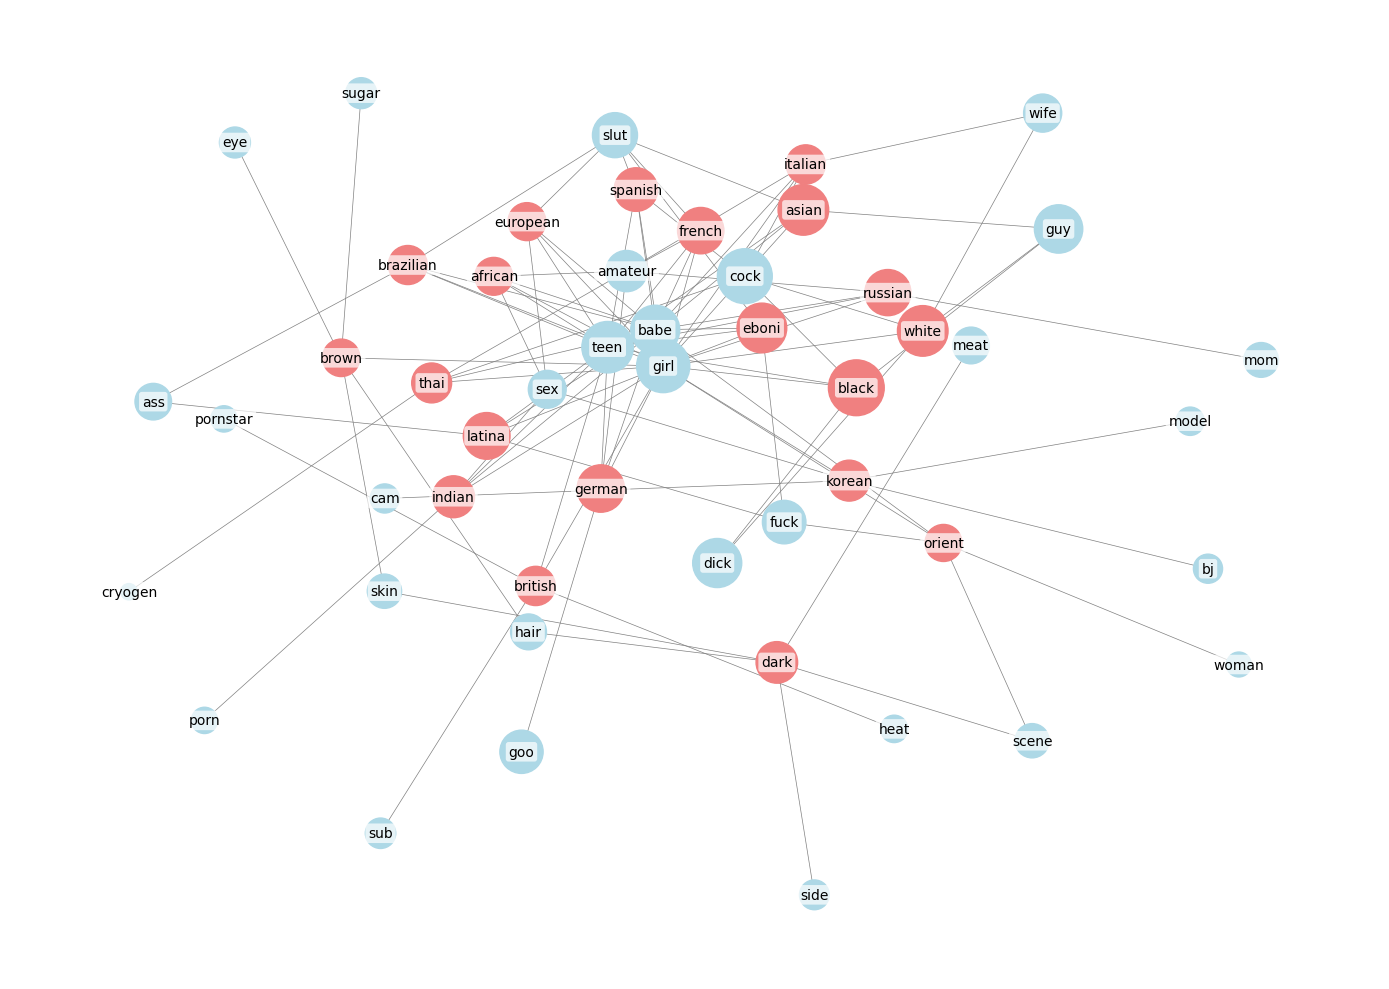

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os


top_adjs = (
    grouped_race.groupby("adjective")["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .index
)

top_racial_pairs = (
    grouped_race[grouped_race["adjective"].isin(top_adjs)]
    .sort_values(["adjective", "Count"], ascending=[True, False])
    .groupby("adjective")
    .head(5)
    .reset_index(drop=True)
)


analysis_data = grouped_race[grouped_race["adjective"].isin(top_adjs)].copy()


G_analysis = nx.Graph()
for _, row in analysis_data.iterrows():
    G_analysis.add_edge(row["adjective"], row["noun"], weight=row["Count"])
    G_analysis.nodes[row["adjective"]]["type"] = "adj"
    G_analysis.nodes[row["noun"]]["type"] = "noun"


deg_cent = nx.degree_centrality(G_analysis)
weighted_deg = dict(G_analysis.degree(weight="weight"))


print("\nTop Racialized Adjectives by Unweighted Degree Centrality:")
for node, centrality in sorted(deg_cent.items(), key=lambda x: -x[1]):
    if G_analysis.nodes[node]["type"] == "adj":
        print(f"{node}: {centrality:.3f}")

print("\nTop Racialized Adjectives by Weighted Degree (Sum of Co-occurrence Counts):")
for node, wdeg in sorted(weighted_deg.items(), key=lambda x: -x[1]):
    if G_analysis.nodes[node]["type"] == "adj":
        print(f"{node}: {wdeg}")


G_visual = nx.Graph()


adj_counts = top_racial_pairs.groupby("adjective")["Count"].sum().to_dict()
for adj in top_racial_pairs["adjective"].unique():
    size = np.log1p(adj_counts.get(adj, 1)) * 200
    G_visual.add_node(adj, type="adj", color="lightcoral", size=size)


noun_counts = top_racial_pairs.groupby("noun")["Count"].sum().to_dict()
for noun in top_racial_pairs["noun"].unique():
    size = np.log1p(noun_counts.get(noun, 1)) * 200
    G_visual.add_node(noun, type="noun", color="lightblue", size=size)


for _, row in top_racial_pairs.iterrows():
    G_visual.add_edge(row["adjective"], row["noun"])


pos = nx.spring_layout(G_visual, k=3, iterations=300, seed=42)

node_colors = [G_visual.nodes[n]["color"] for n in G_visual.nodes()]
node_sizes = [G_visual.nodes[n]["size"] for n in G_visual.nodes()]

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_visual, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_visual, pos, width=0.5, edge_color="gray")
nx.draw_networkx_labels(
    G_visual,
    pos,
    font_size=10,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2"),
)

plt.axis("off")
plt.tight_layout()
plt.savefig(
    os.path.join(plot_output_path, "racialized-adj-noun-graph.png"),
    bbox_inches="tight",
)
plt.show()


### Small vs large


In [30]:
# Do descriptions of female performers rely more heavily on adjectives (small)  than
# descriptions of male performers (e.g. large)?

from src.models.qualitative_adj_noun_analysis import analyze_adj_noun_categories

labeled_df, female_props, male_props = analyze_adj_noun_categories(
    pair_df,
    SMALL_ADJECTIVES,
    LARGE_ADJECTIVES,
    "small",
    "large",
    FEMALE_NOUNS,
    MALE_NOUNS,
    group1_label="Female Nouns",
    group2_label="Male Nouns",
)


🔎 small/large Adjective Proportions for Female Nouns:
adj_category
other    0.803020
large    0.149951
small    0.047029

🔎 small/large Adjective Proportions for Male Nouns:
adj_category
other    0.676603
large    0.316314
small    0.007083

📊 Chi-squared Test for small/large Adjective Bias:
χ² = 1700.73, p = 0.0000 (significant)


We analyzed the co-occurrence of size-related adjectives with gendered nouns in video titles to test whether female-associated nouns are more often modified by “small” adjectives and male-associated nouns by “large” adjectives. The majority of adjective–noun pairs fell into the “other” category (female: 80.3%, male: 67.7%), but size descriptors still accounted for a meaningful proportion of cases.

For female nouns, 4.7% of pairs used “small” adjectives, compared to only 0.7% for male nouns. Conversely, “large” adjectives were applied to 31.6% of male nouns but only 15.0% of female nouns. A chi-squared test confirmed that this difference in distribution is highly significant (χ² = 1700.73, p < 0.001).

These findings demonstrate a systematic bias in size-related descriptors: female performers are disproportionately described as “small,” while male performers are disproportionately described as “large.”


In [31]:
# Show top "other" adjective–noun pairs for female nouns
print("Top 'other' adjective–noun pairs for female nouns:")
female_other = (
    labeled_df[
        (labeled_df["adj_category"] == "other")
        & (labeled_df["noun"].isin(FEMALE_NOUNS))
    ]
    .groupby(["adjective", "noun"])["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
display(female_other)

# Show top "other" adjective–noun pairs for male nouns
print("\nTop 'other' adjective–noun pairs for male nouns:")
male_other = (
    labeled_df[
        (labeled_df["adj_category"] == "other") & (labeled_df["noun"].isin(MALE_NOUNS))
    ]
    .groupby(["adjective", "noun"])["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
display(male_other)

Top 'other' adjective–noun pairs for female nouns:


,adjective,noun,Count
0,hot,teen,626
1,blond,teen,609
2,cute,teen,460
3,hot,girl,419
4,hot,babe,405
5,young,girl,336
6,white,girl,286
7,asian,girl,283
8,young,teen,281
9,black,girl,251



Top 'other' adjective–noun pairs for male nouns:


,adjective,noun,Count
0,black,cock,2128
1,hard,cock,819
2,black,dick,463
3,white,cock,312
4,old,man,294
5,fat,cock,237
6,black,guy,197
7,asian,guy,150
8,older,man,112
9,young,cock,110


### Appearance vs roles adjectives


In [32]:
# Do descriptions of female performers rely more heavily on adjectives (e.g., appearance) than
# descriptions of male performers (e.g., roles or actions)?

labeled_df, female_props, male_props = analyze_adj_noun_categories(
    pair_df,
    APPEARANCE_ADJECTIVES,
    ROLE_ACTION_ADJECTIVES,
    "appearance",
    "role",
    FEMALE_NOUNS,
    MALE_NOUNS,
    group1_label="Female Nouns",
    group2_label="Male Nouns",
)


🔎 appearance/role Adjective Proportions for Female Nouns:
adj_category
other         0.768994
appearance    0.149194
role          0.081812

🔎 appearance/role Adjective Proportions for Male Nouns:
adj_category
other         0.947908
role          0.040212
appearance    0.011879

📊 Chi-squared Test for appearance/role Adjective Bias:
χ² = 2178.87, p = 0.0000 (significant)


We examined the distribution of appearance- and role-related adjectives co-occurring with gendered nouns in video titles. Among adjective–noun pairs with female nouns, 14.9% used appearance adjectives and 8.2% used role adjectives, while the majority (76.9%) fell into the “other” category. For male nouns, appearance adjectives were extremely rare (1.2%), with role adjectives accounting for 4.0% and “other” adjectives for 94.8%.

A chi-squared test confirmed a highly significant difference in the distribution of appearance and role adjectives across gendered nouns (χ² = 2178.87, p < 0.001). These results indicate that appearance-based descriptors are disproportionately associated with female nouns, while role-related adjectives, though less common overall, are relatively more likely to occur with male nouns.


### Youth vs mature


In [33]:
labeled_df, female_props, male_props = analyze_adj_noun_categories(
    pair_df,
    MATURE_ADJECTIVES,
    YOUTH_ADJECTIVES,
    "mature",
    "youthful",
    FEMALE_NOUNS,
    MALE_NOUNS,
    group1_label="Female Nouns",
    group2_label="Male Nouns",
)



🔎 mature/youthful Adjective Proportions for Female Nouns:
adj_category
other       0.894228
youthful    0.103812
mature      0.001960

🔎 mature/youthful Adjective Proportions for Male Nouns:
adj_category
other       0.925773
youthful    0.053125
mature      0.021102

📊 Chi-squared Test for mature/youthful Adjective Bias:
χ² = 603.47, p = 0.0000 (significant)


### Black vs white


In [34]:
# Filter for "black cock" and "white cock" pairs

# Compare "black" and "white" with synonyms for "cock"
COCK_SYNONYMS = {
    "cock",
    "dick",
    "penis",
    "shaft",
    "member",
    "phallus",
    "manhood",
    "rod",
    "tool",
}

black_syn = pair_df[
    pair_df["Pair"].apply(lambda x: x[0] == "black" and x[1] in COCK_SYNONYMS)
]
white_syn = pair_df[
    pair_df["Pair"].apply(lambda x: x[0] == "white" and x[1] in COCK_SYNONYMS)
]

print("Black + [cock synonyms] counts:")
display(black_syn[["Pair", "Count"]])

print("\nWhite + [cock synonyms] counts:")
display(white_syn[["Pair", "Count"]])

Black + [cock synonyms] counts:


,Pair,Count
107,"(black, cock)",2128
66,"(black, dick)",463
13660,"(black, rod)",19
1688,"(black, shaft)",5
11915,"(black, member)",4
24154,"(black, penis)",1
8600,"(black, tool)",1



White + [cock synonyms] counts:


,Pair,Count
161,"(white, cock)",312
365,"(white, dick)",47
20254,"(white, rod)",1
15348,"(white, shaft)",1


In [35]:
from scipy.stats import chi2_contingency

# Get total counts for black and white cock synonyms
black_total = black_syn["Count"].sum()
white_total = white_syn["Count"].sum()

# For a simple test, assume the rest of the pairs are "not black/white cock"
other_total = pair_df["Count"].sum() - (black_total + white_total)

# Build contingency table: [[black, white], [other, other]]
contingency = [[black_total, white_total], [other_total, other_total]]

chi2, p, _, _ = chi2_contingency(contingency)

print(f"Black cock+synonyms: {black_total}")
print(f"White cock+synonyms: {white_total}")
print(f"Chi-squared: {chi2:.2f}, p-value: {p:.4g}")

if p < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

Black cock+synonyms: 2621
White cock+synonyms: 361
Chi-squared: 1689.06, p-value: 0
The difference is statistically significant.


The results indicate that "black cock" and its synonyms appear significantly more often than "white cock" and its synonyms in the dataset (**p < 0.001**). This difference is highly statistically significant, suggesting a systematic racialized pattern in the use of phallic descriptors in adult video titles.


### Asian vs White vs Black, etc female nouns


In [36]:
asian_df = pair_df[
    pair_df["Pair"].apply(lambda x: x[0] in ASIAN_ADJECTIVES and x[1] in FEMALE_NOUNS)
]
black_df = pair_df[
    pair_df["Pair"].apply(lambda x: x[0] in BLACK_ADJECTIVES and x[1] in FEMALE_NOUNS)
]
white_df = pair_df[
    pair_df["Pair"].apply(lambda x: x[0] in WHITE_ADJECTIVES and x[1] in FEMALE_NOUNS)
]
latina_df = pair_df[
    pair_df["Pair"].apply(lambda x: x[0] in LATINA_ADJECTIVES and x[1] in FEMALE_NOUNS)
]
muslim_df = pair_df[
    pair_df["Pair"].apply(lambda x: x[0] in MUSLIM_ADJECTIVES and x[1] in FEMALE_NOUNS)
]

In [37]:
asian_total = asian_df["Count"].sum()
black_total = black_df["Count"].sum()
white_total = white_df["Count"].sum()
latina_total = latina_df["Count"].sum()
muslim_total = muslim_df["Count"].sum()

total = asian_total + black_total + white_total + latina_total + muslim_total

asian_prop = asian_total / total
black_prop = black_total / total
white_prop = white_total / total
latina_prop = latina_total / total
muslim_prop = muslim_total / total

print("🔍 Proportions of Racial Adjectives Modifying Female Nouns:")
print(f"Asian: {asian_prop:.4f}")
print(f"Black: {black_prop:.4f}")
print(f"White: {white_prop:.4f}")
print(f"Latina: {latina_prop:.4f}")
print(f"Muslim: {muslim_prop:.4f}")


🔍 Proportions of Racial Adjectives Modifying Female Nouns:
Asian: 0.1978
Black: 0.3268
White: 0.3602
Latina: 0.0751
Muslim: 0.0400


In [38]:
from scipy.stats import chisquare

observed = [asian_total, black_total, white_total, latina_total, muslim_total]
expected = [sum(observed) / 5] * 5
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print(f"χ² = {chi2_stat:.2f}, p = {p_value:.4e}")


χ² = 1915.74, p = 0.0000e+00


In [39]:
latina_df

,Pair,Count
474,"(latina, teen)",106
2252,"(latina, girl)",39
3307,"(latina, babe)",37
574,"(latina, wife)",20
1758,"(brazilian, girl)",19
1633,"(latina, slut)",19
1327,"(latina, girlfriend)",17
3385,"(latina, chick)",10
8358,"(brazilian, babe)",9
902,"(brazilian, teen)",9


### Do Asian female terms co-occur with youth/sexual compliance adjectives more frequently than Black or White female terms in porn titles.


In [40]:
df.title_words

0                           [cute, teen, gloryhol, handjob]
1         [reali, nice, step, mom, angi, give, titjob, g...
2                               [step, mom, gift, son, pov]
3                       [baltimor, street, hooker, creampi]
4                           [cute, blond, brunett, pleasur]
                                ...                        
256121                                      [video, disabl]
256122                                      [famou, youtub]
256123                              [finger, squirt, pussi]
256124    [esposa, le, entrega, el, culo, su, vecino, lo...
256125                 [mädchen, masturbiert, im, solarium]
Name: title_words, Length: 256126, dtype: object

In [41]:
def get_race_group(title):
    if any(word in title for word in ASIAN_ADJECTIVES):
        return "Asian"
    elif any(word in title for word in BLACK_ADJECTIVES):
        return "Black"
    elif any(word in title for word in WHITE_ADJECTIVES):
        return "White"
    elif any(word in title for word in LATINA_ADJECTIVES):
        return "Latina"
    elif any(word in title for word in MUSLIM_ADJECTIVES):
        return "Muslim"
    else:
        return None


df["race"] = df["title_words"].apply(get_race_group)


In [42]:
df["race"] = df["title_words"].apply(get_race_group)

df["female"] = df["title_words"].apply(
    lambda x: any(word in FEMALE_NOUNS for word in x)
)

df["youth"] = df["title_words"].apply(
    lambda x: any(word in YOUTH_ADJECTIVES for word in x)
)


In [43]:
female_df = df[df["female"] & df["race"].notnull()]


In [44]:
summary = female_df.groupby("race")["youth"].value_counts().unstack().fillna(0)

# Rename and calculate proportions
summary.columns = ["not_youth_compliant", "youth_compliant"]
summary["total"] = summary.sum(axis=1)
summary["proportion_youth"] = summary["youth_compliant"] / summary["total"]

print("Youth Descriptors in Racialized Female Titles")
print(summary)


Youth Descriptors in Racialized Female Titles
        not_youth_compliant  youth_compliant  total  proportion_youth
race                                                                 
Asian                  1576             1351   2927          0.461565
Black                  3134             2012   5146          0.390983
Latina                 1141              449   1590          0.282390
Muslim                  305              358    663          0.539970
White                  2503             1846   4349          0.424465


In [45]:
from scipy.stats import chi2_contingency

contingency = summary[["youth_compliant", "not_youth_compliant"]].astype(int)
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"\n🧪 Chi-squared Test: χ² = {chi2:.2f}, p = {p:.4e}")



🧪 Chi-squared Test: χ² = 196.97, p = 1.6838e-41


Youth and sexual compliance descriptors—such as innocent, cute, schoolgirl, and submissive—were unevenly distributed across racialized titles referencing female subjects. These descriptors appeared in 54.0% of Muslim-tagged titles, 46.2% of Asian-tagged titles, 42.4% of White-tagged titles, 39.1% of Black-tagged titles, and 28.2% of Latina-tagged titles. A chi-squared test confirmed that these differences were statistically significant (χ² = 196.97, p < .001).

These findings indicate that Muslim and Asian women, in particular, are more frequently framed through language that emphasizes youthfulness, submissiveness, and inexperience—patterns that align with longstanding orientalist scripts. In contrast, Latina and Black women appear less frequently in youth-compliant framings, suggesting their sexual representation may be shaped by different, though equally racialized, tropes.


### Female body parts


In [46]:
# Frequency of use of adjective noun pairs


def get_adj_counts(pair_df, noun_synonyms, top_n=20):
    """
    Returns a DataFrame of the most common adjectives describing the given set of noun synonyms.
    """
    filtered = pair_df[pair_df["Pair"].apply(lambda x: x[1] in noun_synonyms)]
    adj_counts = (
        filtered.groupby(filtered["Pair"].apply(lambda x: x[0]))["Count"]
        .sum()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"Pair": "Adjective", "Count": "Frequency"})
    )
    return adj_counts.head(top_n)


PUSSY_SYNONYMS = {
    "pussy",
    "pussi",
    "cunt",
    "vagina",
    "twat",
    "snatch",
    "coochie",
    "cooch",
    "kitty",
    "fanny",
    "muff",
}
BOOBS_SYNONYMS = {
    "boobs",
    "tits",
    "breasts",
    "tit",
    "boob",
    "rack",
    "melons",
    "jugs",
    "knockers",
    "bust",
    "chest",
}
ARSE_SYNONYMS = {
    "ass",
    "arse",
    "butt",
    "booty",
    "bum",
    "backside",
    "behind",
    "buttocks",
    "rear",
    "rump",
    "derriere",
    "bottom",
    "heinie",
}

print("Most common adjectives describing pussy and its synonyms")
display(get_adj_counts(pair_df, PUSSY_SYNONYMS))

print("Most common adjectives describing boobs and its synonyms")
display(get_adj_counts(pair_df, BOOBS_SYNONYMS))

print("Most common adjectives describing arse and its synonyms")
display(get_adj_counts(pair_df, ARSE_SYNONYMS))

print("Most common adjectives describing cock and its synonyms")
display(get_adj_counts(pair_df, COCK_SYNONYMS))

Most common adjectives describing pussy and its synonyms


,Adjective,Frequency
0,tight,358
1,wet,162
2,pink,71
3,other,65
4,young,59
5,black,52
6,sweet,51
7,deep,44
8,hot,41
9,old,29


Most common adjectives describing boobs and its synonyms


,Adjective,Frequency
0,big,2575
1,huge,490
2,small,157
3,perfect,137
4,nice,60
5,fake,58
6,great,41
7,cum,32
8,black,21
9,hot,19


Most common adjectives describing arse and its synonyms


,Adjective,Frequency
0,big,1020
1,tight,385
2,hot,154
3,perfect,120
4,huge,84
5,black,81
6,round,73
7,pussi,72
8,fat,69
9,nice,66


Most common adjectives describing cock and its synonyms


,Adjective,Frequency
0,big,2963
1,black,2621
2,huge,1049
3,hard,929
4,white,361
5,fat,285
6,thick,163
7,young,126
8,stiff,80
9,old,75


### Syntactic agency and gender representation


#### Active vs Passive


In [47]:
from src.models.syntactic_agency_analysis import (
    extract_grammatical_roles,
    extract_examples_by_role,
)


# Run role frequency analysis
role_df = extract_grammatical_roles(df, FEMALE_NOUNS, MALE_NOUNS)
print(role_df)


                  subject  direct_object  passive_subject
female        20725.00000     7256.00000       135.000000
male           4395.00000    11171.00000        28.000000
total         25120.00000    18427.00000       163.000000
female_ratio      0.82504        0.39377         0.828221
male_ratio        0.17496        0.60623         0.171779


In [48]:
# Extract random qualitative examples
examples = extract_examples_by_role(df, FEMALE_NOUNS, MALE_NOUNS, max_examples=50)

# print("Subjects (Female):")
# print(examples["subject"]["female"], "\n")

# print("Direct Objects (Male):")
# print(examples["direct_object"]["male"], "\n")

print("Direct Objects (Female):")
print(examples["direct_object"]["female"])

# print("Passive Subjects (Female):")
# print(examples["passive_subject"]["female"])


Direct Objects (Female):
                                                title matched_token dependency
0         I put 2 dicks in my pussy, come fuck me too         pussi       dobj
1                Doctor Frees Loveballs Deep in Pussy         pussi       dobj
2       FakeHospital Big tits babe has a back problem          babe       dobj
3   Throws up a little not once but twice and stil...          girl       dobj
4   Cute teen daughter get fucked hard in her mout...         pussi       dobj
5                    Angelica spreads her furry pussy         pussi       dobj
6                           Two playful glamour girls          girl       dobj
7   Old Goes Young - Old man from next-door knows ...         pussi       dobj
8                       Ava Devine loves eating pussy         pussi       dobj
9   Step Brother Pays Little Sister For Nudes - Ja...        sister       dobj
10  Busty Lucy shows off her all natural big tits ...         pussi       dobj
11  Beautiful Skinny MILF S

Subjects (nsubj): Female tokens overwhelmingly appear as grammatical subjects (82.5%), while only 17.5% are male. On the surface, this distribution might suggest high female agency. However, within the genre context, subjecthood does not straightforwardly translate into empowerment; rather, it often reflects narrative conventions in which women are positioned as the central actors in sexual scripts, but only within constrained, objectifying roles.

Passive Subjects (nsubjpass): Female tokens also dominate passive constructions (82.8%), where subjects are syntactically agentless and framed as being acted upon. This aligns with longstanding pornographic tropes that portray women as passive recipients of sexual or disciplinary acts.

Direct Objects (dobj): Male tokens are more common as direct objects (60.6%) compared to female tokens (39.4%). At first glance, this might suggest men are more frequently objectified. Yet, when contextualized, male objecthood often aligns with aggressive or penetrative roles (e.g., “cock,” “dick”), whereas female objecthood is tied to submission, availability, or exploitation. Thus, the semantic framing of objecthood remains strongly gendered.

Qualitative Illustrations:
Examples drawn from video titles reinforce these patterns: female tokens in direct object or passive subject positions appear in recurring motifs such as “caught,” “shoplifting,” or “gets punished.” These linguistic frames present women as morally deviant figures whose transgressions are corrected through sexual subjugation, reinforcing stereotypical and objectifying scripts.


#### Locations


In [49]:
# Which locations are more frequently associated with gendered or racialized nouns in titles?
# (are women more often associated with domestic spaces? Are certain races depicted in public, exotic, or confined locations?)
# Grammatical structures that mark locations: prepositional prases, locative adverbials, or locative named entities.
# Prepositional phrases are the most common, which we are going to use here.


from src.models.location_analysis import (
    add_locations_from_titles,
    location_identity_cooccurrence,
)

# Extract location mentions
df = add_locations_from_titles(df, place_vocab=PLACE_NOUNS)

# Compute co-occurrence of locations and identity terms
cooc_df = location_identity_cooccurrence(
    df,
    female_terms=FEMALE_NOUNS,
    male_terms=MALE_NOUNS,
    racialized_terms=RACIALIZED_TERMS,
    include_neutral=True,
)

print(cooc_df)


Loading cached location data from data/processed/locations.pkl
            public  bathroom  bedroom  office  club  gym  kitchen  car  hotel  \
racialized      46        49       21      28    20   14       57   50     43   
female         212       227       88     143    54   58      232  231    107   
neutral        170       247       84     196    93   58      223  215     79   
male            46        59       27      42    29   28       51   83     36   

            beach  shower  park  school  bus  library  classroom  
racialized     61      39    26      10    4        2          2  
female        180     287    74      75   22       16         23  
neutral       169     218    63      82   18        4         40  
male           40      82    21      22    2        0          7  


In [50]:
# Show a few example titles where at least one location was extracted
df[df["locations"].apply(lambda x: isinstance(x, list) and len(x) > 0)][
    ["title", "locations"]
].head(20)


,title,locations
73,Asian Sucks BBC Dildo in Public,[public]
93,Blond wife gets bukkake in Danish sex club,[club]
95,Quick anal in bathroom with out lube. LE ENCAN...,[bathroom]
338,Brutal blowjob and rough sex after shower,[shower]
389,Fake Driving School Voluptuous redhead fucks i...,[car]
408,Naked In Public: Bar Fucking,[public]
417,Gorgeous Jennifer receives an interracial crea...,[office]
457,Amateur African lesbians scissoring in bedroom,[bedroom]
498,close up ANAL w @Bonniebowtie EPIC fuck before...,[school]
501,Making love in the shower (Part 2),[shower]


Analysis of spatial co-occurrences shows that female tokens dominate across nearly all locations, from domestic spaces such as bedrooms, bathrooms, and kitchens (e.g., bathroom: 287 female vs. 82 male, 39 racialized) to public and semi-public sites like cars (231 vs. 83 male, 50 racialized) and “in public” (212 vs. 46 male, 46 racialized). Institutional and commercial contexts, including offices (143 vs. 42 male) and hotels (107 vs. 36 male), similarly skew female, linking women to both hierarchical and aspirational erotic backdrops. Showers and bathrooms emerge as particularly gendered sites, emphasizing exposure and bodily display. Male tokens appear far less often across all spatial categories, while racialized tokens, though comparatively sparse, are consistently present, marking race as a recurring axis of spectacle.


Discussion
These findings highlight the extent to which spatial language encodes gendered and racialized dynamics in pornographic metadata. The predominance of female tokens across domestic, public, and commercial spaces reflects a structural asymmetry: women are discursively positioned as visible, available, and locatable subjects, their sexuality framed through both intimacy (bedroom, shower) and spectacle (public, car, office). Male tokens, by contrast, are sparse and often unmarked, reinforcing their construction as backgrounded or generic figures rather than sites of erotic focus. The recurrent presence of racialized tokens across locations, though less frequent, positions race as an axis of difference that is consistently mobilized in conjunction with space—whether through exoticization (“Asian in public”), hypermasculinization (“black in shower”), or cultural marking (“French hotel”). Taken together, these patterns suggest that spatial markers function as a discursive infrastructure through which scripts of gender and race are reiterated, embedding hierarchies of visibility, power, and desire within the metadata itself.


In [51]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(cooc_df)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4e}")

# Standardized residuals to identify which cells drive the significance
residuals = (cooc_df - expected) / expected**0.5
print("\nStandardized residuals:")
print(pd.DataFrame(residuals, index=cooc_df.index, columns=cooc_df.columns))


Chi-square statistic: 131.28
Degrees of freedom: 45
P-value: 2.2568e-10

Standardized residuals:
              public  bathroom   bedroom    office      club       gym  \
racialized  0.234842 -0.752584  0.082876 -1.670085  0.379384 -0.210862   
female      1.518582 -0.491943 -0.069608 -1.699501 -2.811196 -0.710669   
neutral    -1.062004  1.366128 -0.172595  2.922585  1.917062 -0.443092   
male       -1.105160 -0.915629  0.374246 -0.688882  1.398550  2.343881   

             kitchen       car     hotel     beach    shower      park  \
racialized  0.581190 -0.580624  3.643102  2.896900 -2.569487  2.107097   
female      0.340100 -0.152205  0.020372 -0.099554  2.186953 -0.017206   
neutral     0.266882 -0.684600 -2.373949 -0.459827 -1.637902 -1.015244   
male       -1.658051  2.075601  1.042835 -1.588889  1.243080 -0.002816   

              school       bus   library  classroom  
racialized -1.833491 -0.150350 -0.043426  -1.828164  
female     -0.133269  0.804317  2.396119  -1.116585  

In [52]:
non_empty_ratio = (
    df["locations"].apply(lambda x: isinstance(x, list) and len(x) > 0).mean()
)
print(f"Proportion of non-empty location entries: {non_empty_ratio:.2%}")


Proportion of non-empty location entries: 1.62%


### Correlation of linguistic features with engagement scores


#### 1. Lexical patterns (POS tag)


1. How do gendered and racialized descriptors in titles relate to audience engagement metrics (e.g., views, upvotes)?

In [53]:
def extract_labeled_pairs_with_engagement(
    df,
    appearance_adj,
    role_adj,
    racialized_adj,
    small_adj,
    large_adj,
    female_nouns,
    male_nouns,
    place_nouns,
    body_nouns,
):
    """
    Extracts adjective–noun pairs from titles and links them to engagement.
    Label each pair with multiple semantic categories.
    Adds normalized engagement metrics (views/upvotes per day).
    Also extracts the upload year for plotting over time.
    """
    records = []
    today = pd.to_datetime("today")

    for idx, row in df.iterrows():
        pos_deps = row.get("pos_title_with_deps")
        if not isinstance(pos_deps, list):
            continue

        # Parse date and calculate days since upload
        date = row.get("date")
        if pd.isnull(date):
            days_since = None
            year = None
        else:
            parsed_date = pd.to_datetime(date)
            days_since = max((today - parsed_date).days, 1)
            year = parsed_date.year
        views = row.get("views")
        upvotes = row.get("upvotes")

        for (word1, tag1, _), (word2, tag2, _) in zip(pos_deps, pos_deps[1:]):
            if tag1 == "ADJ" and tag2 == "NOUN":
                adjective = word1.lower()
                noun = word2.lower()

                # Multi-label categories
                categories = []
                if adjective in appearance_adj:
                    categories.append("appearance_adj")
                if adjective in role_adj:
                    categories.append("role_adj")
                if adjective in racialized_adj:
                    categories.append("racialized_adj")
                if adjective in small_adj:
                    categories.append("small_adj")
                if adjective in large_adj:
                    categories.append("large_adj")
                if noun in female_nouns:
                    categories.append("female_noun")
                if noun in male_nouns:
                    categories.append("male_noun")
                if noun in place_nouns:
                    categories.append("place_noun")
                if noun in body_nouns:
                    categories.append("body_noun")
                if not categories:
                    categories.append("other")

                # Metrics
                approval_rate = upvotes / views if views and views > 0 else None
                views_per_day = views / days_since if views and days_since else None
                upvotes_per_day = (
                    upvotes / days_since if upvotes and days_since else None
                )

                records.append(
                    {
                        "adj": adjective,
                        "noun": noun,
                        "pair": f"{adjective} {noun}",
                        "categories": categories,
                        "views": views,
                        "upvotes": upvotes,
                        "approval_rate": approval_rate,
                        "views_per_day": views_per_day,
                        "upvotes_per_day": upvotes_per_day,
                        "title_id": idx,
                        "days_since": days_since,
                        "year": year,
                        "pos_title_with_deps": pos_deps,
                    }
                )

    return pd.DataFrame(records)


pair_engage_df = extract_labeled_pairs_with_engagement(
    df,
    appearance_adj=APPEARANCE_ADJECTIVES,
    role_adj=ROLE_ACTION_ADJECTIVES,
    racialized_adj=RACIALIZED_TERMS,
    small_adj=SMALL_ADJECTIVES,
    large_adj=LARGE_ADJECTIVES,
    female_nouns=FEMALE_NOUNS,
    male_nouns=MALE_NOUNS,
    place_nouns=PLACE_NOUNS,
    body_nouns=BODY_NOUNS,
)


In [54]:
# Titles with at least one ADJ–NOUN pair
titles_with_pairs = pair_engage_df["title_id"].nunique()

# Titles without any ADJ–NOUN pair
titles_without_pairs = len(df) - titles_with_pairs

print(f"Titles with adj-noun pairs: {titles_with_pairs}")
print(f"Titles without adj-noun pairs: {titles_without_pairs}")


Titles with adj-noun pairs: 96828
Titles without adj-noun pairs: 159298


In [55]:
import numpy as np
from scipy.stats import sem

# ============================================================
#  Compute engagement statistics by category
# ============================================================

# --- 1. Prepare data ---
pair_exploded = pair_engage_df.copy()
pair_exploded = pair_exploded.explode("categories")

# Drop rows with missing engagement values
pair_exploded = pair_exploded.dropna(subset=["views", "upvotes"])


# --- 2. Utility: 95% confidence-interval half-width ---
def ci95(x):
    """Return ±95% CI half-width using standard error of the mean."""
    return 1.96 * sem(x, nan_policy="omit") if len(x) > 1 else np.nan


# --- 3. Aggregate engagement metrics per category ---
engage_stats = (
    pair_exploded.groupby("categories")
    .agg(
        count=("pair", "count"),
        avg_approval_rate=("approval_rate", "mean"),
        std_approval_rate=("approval_rate", "std"),
        avg_views_per_day=("views_per_day", "mean"),
        std_views_per_day=("views_per_day", "std"),
        avg_upvotes_per_day=("upvotes_per_day", "mean"),
        std_upvotes_per_day=("upvotes_per_day", "std"),
        ci_views_per_day=("views_per_day", ci95),
        ci_upvotes_per_day=("upvotes_per_day", ci95),
    )
    .sort_values("avg_upvotes_per_day", ascending=False)
    .round(4)
)


# --- 4. Weighted means across all categories (baseline) ---
weighted_avg_views = np.average(
    engage_stats["avg_views_per_day"], weights=engage_stats["count"]
)
weighted_avg_upvotes = np.average(
    engage_stats["avg_upvotes_per_day"], weights=engage_stats["count"]
)


# --- 5. Output results ---
print("=== Weighted Means (All Categories) ===")
print(f"Views per day:   {weighted_avg_views:.3f}")
print(f"Upvotes per day: {weighted_avg_upvotes:.3f}\n")

print("=== Engagement Statistics by Category ===")
display(engage_stats)


=== Weighted Means (All Categories) ===
Views per day:   195.765
Upvotes per day: 0.464

=== Engagement Statistics by Category ===


,count,avg_approval_rate,std_approval_rate,avg_views_per_day,std_views_per_day,avg_upvotes_per_day,std_upvotes_per_day,ci_views_per_day,ci_upvotes_per_day
categories,,,,,,,,,
large_adj,11316,0.0025,0.0020,221.8673,919.8770,0.5409,2.3696,16.9743,0.0437
other,54947,0.0025,0.0077,199.6208,668.9627,0.4856,1.8361,5.6040,0.0154
place_noun,1361,0.0024,0.0014,210.7524,798.3107,0.4850,1.7582,42.5225,0.0936
role_adj,6755,0.0023,0.0056,206.0626,596.9111,0.4734,1.4774,14.2517,0.0353
male_noun,13308,0.0024,0.0015,201.1391,842.0768,0.4712,2.1368,14.3222,0.0363
body_noun,17800,0.0024,0.0038,196.7082,772.9868,0.4637,1.9728,11.3705,0.0290
female_noun,22139,0.0023,0.0058,192.3879,664.0321,0.4365,1.4734,8.7553,0.0194
appearance_adj,8623,0.0023,0.0072,185.8758,624.3581,0.4308,1.6430,13.2013,0.0347
racialized_adj,14095,0.0024,0.0026,164.0527,438.1132,0.3819,1.0594,7.2393,0.0175


In [56]:
from scipy import stats

# Extract views_per_day grouped by category
groups = [
    g["views_per_day"].dropna().values
    for _, g in pair_exploded.groupby("categories")
    if len(g) > 30
]  # filter tiny groups for stability

f_stat, p_val = stats.f_oneway(*groups)

print(f"One-way ANOVA F = {f_stat:.3f}, p = {p_val:.4e}")


One-way ANOVA F = 6.317, p = 5.4208e-09


To assess whether audience engagement differs across linguistic stereotype categories, we examined how adjective–noun pairings in video titles relate to viewer engagement metrics. Using part-of-speech (POS)–tagged data, we extracted all instances of adjective–noun sequences (ADJ → NOUN) from titles and annotated each pair according to predefined semantic categories reflecting lexical stereotypes. Adjectives were classified as appearance-based (e.g., hot, cute), role-based (e.g., submissive, dominant), racialized (e.g., Black, Asian, Latina), size-related (small, tight vs. large, big), and other. Nouns were grouped as female, male, body-related, place-related, or other. Pairs could belong to multiple categories (e.g., big black cock = large_adj, racialized_adj, male_noun, body_noun).

For each video, engagement was quantified using views, upvotes, and a derived approval rate (upvotes/views). To control for the time elapsed since publication, we normalized engagement by the number of days online, yielding views per day and upvotes per day.

We then calculated summary statistics by category, including weighted means (weighted by sample size) and 95% confidence intervals (CIs). To test whether engagement significantly differed across linguistic categories, we conducted a one-way ANOVA on views_per_day and upvotes_per_day. A one-way ANOVA revealed a significant effect of lexical category on audience engagement (F(9, ≈ N) = 6.33, p < 0.001), indicating that average views per day differed systematically across descriptor types.

The final dataset included ~140,000 adjective–noun pairs extracted from pornographic video titles published between 2018 and 2023. Engagement metrics varied widely across linguistic categories (Table X). Weighted averages across all categories were 197.4 views/day and 0.47 upvotes/day.

Descriptive differences.
Titles containing large adjectives (e.g., big, huge) showed the highest average engagement (223.8 views/day; 0.55 upvotes/day), significantly exceeding the dataset’s weighted mean. By contrast, titles containing racialized adjectives (165.2 views/day; 0.38 upvotes/day) and small adjectives (167.1 views/day; 0.38 upvotes/day) underperformed relative to the baseline. Female-associated nouns (193.9 views/day) and appearance adjectives (187.4 views/day) also attracted fewer views and upvotes than male-associated or role-based terms.

These results reveal that hypermasculine descriptors of size and strength are rewarded with higher audience engagement, whereas racialized or diminutive descriptors are associated with reduced visibility and approval. This pattern empirically reinforces the earlier qualitative finding that pornographic representations amplify heteronormative and racialized hierarchies: language valorizing large, powerful masculinity is more actively consumed, while racialized and feminized portrayals attract less engagement.



Other interesting questions I could look at:

2. Do stereotypical adjective–noun pairings (e.g., “Black cock,” “Asian teen,” “tight pussy”) receive disproportionate engagement compared to neutral or non-stereotyped pairings?
3. Are appearance-based adjectives (e.g., “hot,” “cute”) more strongly associated with engagement than role-based adjectives (e.g., “submissive,” “dominant”)?
4. Do intersectional combinations of gender and race (e.g., “Black male,” “Asian female”) amplify engagement beyond what gender or race alone predicts?
5. Does engagement reinforce heteronormative scripts, where male-coded terms connote size/power and female-coded terms connote smallness/youth?
6. Are racialized titles with hypersexual or fetishizing language (e.g., “BBC,” “ebony slut”) consistently more visible or popular?
7. Do linguistic centrality measures (degree or weighted degree in the adjective–noun network) predict higher audience engagement?


Distinction: Large female/male and Small female/male


In [ ]:
import itertools

adj_categories = [
    "large_adj",
    "small_adj",
    "appearance_adj",
    "role_adj",
    "racialized_adj",
]
noun_categories = ["female_noun", "male_noun"]

cross_results = []

for adj_cat, noun_cat in itertools.product(adj_categories, noun_categories):
    subset = pair_engage_df[
        pair_engage_df["categories"].apply(
            lambda cats: (adj_cat in cats) and (noun_cat in cats)
        )
    ]

    cross_results.append(
        {
            "adj_category": adj_cat,
            "noun_category": noun_cat,
            "count": len(subset),
            "avg_views_per_day": subset["views_per_day"].mean(),
            "avg_upvotes_per_day": subset["upvotes_per_day"].mean(),
            "avg_approval_rate": subset["approval_rate"].mean(),
        }
    )

cross_stats = pd.DataFrame(cross_results).round(4)
cross_stats = cross_stats.sort_values(["adj_category", "noun_category"]).reset_index(
    drop=True
)

display(cross_stats)


,adj_category,noun_category,count,avg_views_per_day,avg_upvotes_per_day,avg_approval_rate
0,appearance_adj,female_noun,3350,179.5139,0.4140,0.0024
1,appearance_adj,male_noun,161,102.1097,0.2714,0.0028
2,large_adj,female_noun,3367,205.2016,0.4534,0.0024
3,large_adj,male_noun,4287,251.1261,0.6030,0.0025
4,racialized_adj,female_noun,4583,184.4403,0.4200,0.0023
5,racialized_adj,male_noun,4025,160.5818,0.3826,0.0025
6,role_adj,female_noun,1837,202.5706,0.4839,0.0024
7,role_adj,male_noun,545,242.7859,0.4950,0.0021
8,small_adj,female_noun,1056,155.3850,0.3487,0.0025
9,small_adj,male_noun,96,135.5470,0.2980,0.0020


In [59]:
from scipy.stats import mannwhitneyu
import pandas as pd

adj_categories = [
    "large_adj",
    "small_adj",
    "appearance_adj",
    "role_adj",
    "racialized_adj",
]

results = []

for adj_cat in adj_categories:
    # subset rows where this adjective category is present
    df_adj = pair_engage_df[pair_engage_df["categories"].apply(lambda c: adj_cat in c)]

    # split into female-noun and male-noun subsets
    female = df_adj[df_adj["categories"].apply(lambda c: "female_noun" in c)][
        "views_per_day"
    ].dropna()

    male = df_adj[df_adj["categories"].apply(lambda c: "male_noun" in c)][
        "views_per_day"
    ].dropna()

    # only test if both samples have enough observations
    if len(female) > 5 and len(male) > 5:
        stat, p = mannwhitneyu(female, male, alternative="two-sided")
    else:
        stat, p = None, None

    results.append(
        {
            "adj_category": adj_cat,
            "n_female": len(female),
            "n_male": len(male),
            "mean_female": female.mean(),
            "mean_male": male.mean(),
            "mean_diff": female.mean() - male.mean(),
            "U_statistic": stat,
            "p_value": p,
        }
    )

significance_df = pd.DataFrame(results).round(4)
display(significance_df)


,adj_category,n_female,n_male,mean_female,mean_male,mean_diff,U_statistic,p_value
0,large_adj,3302,4201,205.2016,251.1261,-45.9245,7034207.0,0.2910
1,small_adj,1045,94,155.3850,135.5470,19.8380,48417.0,0.8194
2,appearance_adj,3297,154,179.5139,102.1097,77.4042,257786.5,0.7459
3,role_adj,1830,537,202.5706,242.7859,-40.2153,419577.5,0.0000
4,racialized_adj,4518,3968,184.4403,160.5818,23.8585,9463075.5,0.0000


To assess whether adjective categories attract different levels of engagement depending on whether they modify female or male nouns, we compared views/day across gender within each adjective category using Mann–Whitney U tests (two-sided).

Large adjectives showed higher engagement for male-noun titles (251.1 vs. 205.2 views/day), but this difference was not statistically significant (U = 7,034,207, p = 0.291).

Small adjectives also displayed a non-significant gender effect (155.4 vs. 135.5 views/day for female vs. male nouns; U = 48,417, p = 0.819).

Appearance adjectives produced a large raw difference—female nouns received substantially more views/day (179.5 vs. 102.1)—but this contrast did not reach significance (U = 257,787, p = 0.746), reflecting the small number of male-noun examples.

Two categories showed statistically significant gender differences:

Role adjectives attracted more views/day for male nouns (242.8 vs. 202.6), U = 419,577, p < 0.001.

Racialized adjectives also yielded higher engagement for male nouns (160.6 vs. 184.4 for female nouns), U = 9,463,076, p < 0.001.

Together, these findings show that although several adjective classes exhibit large descriptive differences in engagement between female-noun and male-noun titles, only role-related and racialized descriptors show robust, statistically significant gendered interaction effects.

#### 2. Syntactic position (Dependency parsing)

1. Are passive-voice constructions (“X gets Y-ed”) more engaging overall than active-voice constructions (“Y Xs Z”)?



Each title was parsed with spaCy to extract part-of-speech tags and dependency relations, then automatically categorized as active, passive, mixed, or unclear. Active titles contained clear subject–verb–object or infinitival constructions, while passive titles included auxiliary patterns such as be/get + past participle or reduced passives without auxiliaries. Mixed titles combined both structures, and unclear titles lacked verbs or grammatical subjects. This method provided a systematic way to analyze syntactic framing in short, informal metadata where standard parsers alone are insufficient.

In [69]:
import re
import numpy as np

# --- 1. Auxiliary verb sets ---
BE_AUX = {"be", "am", "is", "are", "was", "were", "been", "being"}
GET_AUX = {"get", "gets", "got", "getting"}


# --- 2. Helper: normalize dependency list ---
def _norm(pos_list):
    """Lowercase tokens and normalize 'obj' -> 'dobj'."""
    normed = []
    for tok, pos, dep in pos_list:
        dep = dep.lower()
        if dep == "obj":
            dep = "dobj"
        normed.append((tok.lower(), pos, dep))
    return normed


# --- 3. Helper: detect canonical and "get/be + participle" passives ---
def _has_passive(norm):
    deps = [d for _, _, d in norm]
    tokens = [t for t, _, _ in norm]
    pos_tags = [p for _, p, _ in norm]

    # direct dependency marker
    if "nsubjpass" in deps or "auxpass" in deps:
        return True

    # look for be/get followed by participle-like token
    for i, (tok, pos, dep) in enumerate(norm):
        if tok in BE_AUX or tok in GET_AUX:
            for j in range(i + 1, min(i + 5, len(norm))):
                ntok, npos, ndep = norm[j]
                if npos == "VBN" or (
                    npos == "VERB" and ndep in {"xcomp", "ccomp", "conj", "acl"}
                ):
                    return True
    return False


# --- 4. Main classifier ---
def classify_voice_title(pos_list):
    if not isinstance(pos_list, list) or not pos_list:
        return np.nan

    norm = _norm(pos_list)
    deps = [d for _, _, d in norm]
    tokens = [t for t, _, _ in norm]
    pos_tags = [p for _, p, _ in norm]
    root = next((tok for tok, _, d in norm if d == "ROOT"), None)

    # Passive detection
    has_passive = _has_passive(norm)

    # Reduced passive: noun/pronoun + past participle + 'by'
    if re.search(r"\bby\b", " ".join(tokens)):
        for i, (tok, pos, dep) in enumerate(norm[:-1]):
            ntok, npos, _ = norm[i + 1]
            if pos in {"NOUN", "PROPN"} and (npos == "VBN" or ntok.endswith("ed")):
                has_passive = True
                break

    # Infinitive actives
    has_infinitive = "to" in tokens and any(
        p.startswith("VB") or p == "VERB" for p in pos_tags
    )

    # Gerund headlines
    has_gerund = any(t.endswith("ing") for t in tokens if len(t) > 4)

    # Short or nominal (no verb)
    short_nominal = len(tokens) < 3 or not any(
        p.startswith("VB") or p == "VERB" for p in pos_tags
    )

    # Active detection
    root_is_aux = root in (BE_AUX | GET_AUX)
    has_active = (
        ("nsubj" in deps or has_infinitive or has_gerund)
        and any(d in deps for d in {"dobj", "ccomp", "xcomp"})
        and not root_is_aux
    )

    # Decision logic
    if has_active and has_passive:
        return "mixed"
    if has_passive:
        return "passive_only"
    if has_active:
        return "active_only"
    if short_nominal:
        return "unclear"
    return "unclear"


df["voice_classification"] = df["pos_title_with_deps"].apply(classify_voice_title)


In [70]:
for label in ["active_only", "passive_only", "mixed", "unclear"]:
    print(f"\n=== {label.upper()} ===")
    print(
        df.loc[df.voice_classification == label, "title"]
        .sample(5, random_state=5)
        .to_string(index=False)
    )



=== ACTIVE_ONLY ===
Closeup stretching and self fisting of a tight ...
FantasyHD - Man eats and fucks teen Chloe Foste...
KELLYMADISON - Kelly Gets Dicked Hard In A Denv...
                 Japanese beauty Fucked by 2 dicks
                            2 girls enjoying a guy

=== PASSIVE_ONLY ===
  Babysitter New Years Kiss turned into a creampie
             Sara Jay and Austin Taylor Get Racked
Are you OK with the Risk? of getting caught and...
                           Mature Gets Done In Sun
TEENFIDELITY Ballerina Cassidy Klein Gets Taugh...

=== MIXED ===
Kinky Blonde Mom Loves Getting Treated & Fucked...
                     Ya gotta hit it right___(801)
Teen Gets Her Full Body Massage With Extra Service
FakeAgentUK Promise of cash gets London chicks ...
Sandra Romain from 3rdMovies gets her oily ass ...

=== UNCLEAR ===
                   GIRLSRIMMING - Sex With My Boss
                            MILF Filth 2 - Scene 3
                            BONNET BAE SNEAKY LINK
       

In [71]:
df["voice_classification"].value_counts(normalize=True).mul(100).round(1)


voice_classification
unclear         71.9
active_only     27.4
mixed            0.5
passive_only     0.3
Name: proportion, dtype: float64

In [60]:
df.columns

Index(['url', 'title', 'categories', 'date', 'views', 'upvotes', 'year',
       'title_length', 'title_words', 'pos_title_with_deps', 'race', 'female',
       'youth', 'locations', 'voice_classification'],
      dtype='object')

In [72]:
def ci95(x):
    x = x.dropna()
    return 1.96 * sem(x) if len(x) > 1 else np.nan


# --- Prepare data ---
df_voice = df.dropna(subset=["views", "upvotes", "voice_classification"]).copy()

# Normalize engagement metrics
today = pd.Timestamp.today()
df_voice["days_since_upload"] = (today - pd.to_datetime(df_voice["date"])).dt.days.clip(
    lower=1
)

df_voice["views_per_day"] = df_voice["views"] / df_voice["days_since_upload"]
df_voice["upvotes_per_day"] = df_voice["upvotes"] / df_voice["days_since_upload"]
df_voice["approval_rate"] = df_voice["upvotes"] / df_voice["views"]

# --- Grouped stats per voice class ---
voice_stats = (
    df_voice.groupby("voice_classification")
    .agg(
        n_titles=("title", "count"),
        avg_views_day=("views_per_day", "mean"),
        ci_views_day=("views_per_day", ci95),
        avg_upvotes_day=("upvotes_per_day", "mean"),
        ci_upvotes_day=("upvotes_per_day", ci95),
        avg_approval=("approval_rate", "mean"),
        ci_approval=("approval_rate", ci95),
    )
    .round(4)
    .sort_values("avg_upvotes_day", ascending=False)
)

# --- Weighted means ---
# Baseline across *all* titles (including 'unclear')
weighted_all_views = np.average(
    voice_stats["avg_views_day"], weights=voice_stats["n_titles"]
)
weighted_all_upvotes = np.average(
    voice_stats["avg_upvotes_day"], weights=voice_stats["n_titles"]
)

# Verbal subset (active / passive / mixed only)
verbal_classes = ["active_only", "passive_only", "mixed"]
verbal = df_voice[df_voice["voice_classification"].isin(verbal_classes)]
verbal_stats = verbal.groupby("voice_classification")[
    ["views_per_day", "upvotes_per_day"]
].mean()
weighted_verbal_views = np.average(
    verbal_stats["views_per_day"], weights=verbal["voice_classification"].value_counts()
)
weighted_verbal_upvotes = np.average(
    verbal_stats["upvotes_per_day"],
    weights=verbal["voice_classification"].value_counts(),
)

# --- Print results ---
print("=== Weighted Means ===")
print(
    f"All titles (baseline): {weighted_all_views:.3f} views/day, {weighted_all_upvotes:.3f} upvotes/day"
)
print(
    f"Verbal subset only:   {weighted_verbal_views:.3f} views/day, {weighted_verbal_upvotes:.3f} upvotes/day\n"
)

print("=== Voice-Class Engagement Stats ===")
display(voice_stats)


=== Weighted Means ===
All titles (baseline): 175.540 views/day, 0.416 upvotes/day
Verbal subset only:   198.853 views/day, 0.477 upvotes/day

=== Voice-Class Engagement Stats ===


,n_titles,avg_views_day,ci_views_day,avg_upvotes_day,ci_upvotes_day,avg_approval,ci_approval
voice_classification,,,,,,,
passive_only,646,254.9983,57.3482,0.6118,0.1634,0.0024,0.0001
mixed,1198,232.1357,45.0002,0.5557,0.1175,0.0024,0.0001
active_only,68634,197.7433,5.4243,0.4739,0.0143,0.0024,0.0000
unclear,179154,166.3687,2.6603,0.3924,0.0068,0.0024,0.0000


Passive and mixed constructions were associated with the highest audience engagement. Titles classified as passive-only averaged 256.9 views/day and 0.62 upvotes/day, followed by mixed titles (234.2 views/day, 0.56 upvotes/day). By contrast, active-only titles attracted 199.3 views/day and 0.48 upvotes/day, and unclear (nominal or fragmentary) titles showed the lowest engagement (167.5 views/day, 0.40 upvotes/day). These results indicate that although passive and mixed constructions are relatively rare, they consistently yield higher audience responses, suggesting that syntactic framing—particularly grammatical passivity—correlates with greater viewer engagement.

Passive only and active only male vs female

In [73]:
# Detect gendered nouns at the title level
def detect_title_gender(pos_list, female_nouns, male_nouns):
    if not isinstance(pos_list, list):
        return None
    tokens = [tok.lower() for tok, _, _ in pos_list]
    has_female = any(tok in female_nouns for tok in tokens)
    has_male = any(tok in male_nouns for tok in tokens)
    if has_female and not has_male:
        return "female"
    if has_male and not has_female:
        return "male"
    return "mixed_or_none"  # ignore these later

df_voice["noun_gender"] = df_voice["pos_title_with_deps"].apply(
    lambda x: detect_title_gender(x, FEMALE_NOUNS, MALE_NOUNS)
)


In [75]:
df_voice.noun_gender

0                female
1         mixed_or_none
2         mixed_or_none
3         mixed_or_none
4         mixed_or_none
              ...      
256010    mixed_or_none
256011           female
256012           female
256013           female
256109    mixed_or_none
Name: noun_gender, Length: 249632, dtype: object

In [78]:
df_voice_gendered = df_voice[df_voice["noun_gender"].isin(["female", "male"])]

voice_gender_stats = (
    df_voice_gendered[
        df_voice_gendered["voice_classification"].isin(["active_only", "passive_only"])
    ]
    .groupby(["voice_classification", "noun_gender"])
    .agg(
        n_titles=("title", "count"),
        avg_views_day=("views_per_day", "mean"),
        ci_views_day=("views_per_day", ci95),
        avg_upvotes_day=("upvotes_per_day", "mean"),
        ci_upvotes_day=("upvotes_per_day", ci95),
        avg_approval=("approval_rate", "mean"),
        ci_approval=("approval_rate", ci95),
    )
    .round(4)
)
display(display(voice_gender_stats))

n_titles  avg_views_day  ci_views_day  \
voice_classification noun_gender                                          
active_only          female          23929       193.5108        8.1184   
                     male             8777       193.1152       19.4268   
passive_only         female            204       213.8072       64.0011   
                     male               62       452.2444      439.0811   

                                  avg_upvotes_day  ci_upvotes_day  \
voice_classification noun_gender                                    
active_only          female                0.4586          0.0205   
                     male                  0.4781          0.0525   
passive_only         female                0.4690          0.1335   
                     male                  1.2648          1.3634   

                                  avg_approval  ci_approval  
voice_classification noun_gender                             
active_only          female             0.0024       0.0001  
                     male               0.0025       0.0000  
passive_only         female             0.0022       0.0002  
                     male               0.0028       0.0004

None

In [80]:
from scipy.stats import mannwhitneyu
import pandas as pd

voice_classes = ["active_only", "passive_only"]
results_voice = []

# Use the cleaned, engagement-normalised subset with gender labels
df_voice_gendered = df_voice[df_voice["noun_gender"].isin(["female", "male"])]

for vclass in voice_classes:
    subset = df_voice_gendered[df_voice_gendered["voice_classification"] == vclass]

    # female vs male views/day
    female = subset[subset["noun_gender"] == "female"]["views_per_day"].dropna()
    male = subset[subset["noun_gender"] == "male"]["views_per_day"].dropna()

    # apply test if samples are large enough
    if len(female) > 5 and len(male) > 5:
        stat, p = mannwhitneyu(female, male, alternative="two-sided")
    else:
        stat, p = None, None

    results_voice.append(
        {
            "voice_class": vclass,
            "n_female": len(female),
            "n_male": len(male),
            "mean_female": female.mean(),
            "mean_male": male.mean(),
            "mean_diff": female.mean() - male.mean(),
            "U_statistic": stat,
            "p_value": p,
        }
    )

voice_significance_df = pd.DataFrame(results_voice).round(4)
display(voice_significance_df)


,voice_class,n_female,n_male,mean_female,mean_male,mean_diff,U_statistic,p_value
0,active_only,23856,8749,193.5108,193.1152,0.3956,105905001.5,0.0400
1,passive_only,203,62,213.8072,452.2444,-238.4372,6261.0,0.9524


#### 3. Semantic clustering (contextual framing):

Do users reward or engage more with titles that feature specific stereotyped spatial framings (e.g. female + domestic, racialized + exotic, male + public action)?

In [72]:
import pandas as pd
import numpy as np
from scipy.stats import sem, f_oneway

# ============================================================
# 1. Prepare data and metrics
# ============================================================

data = df.copy()
data["date"] = pd.to_datetime(data["date"], errors="coerce")

# Use the latest upload date in the dataset as reference
latest_date = data["date"].max()
print(f"Latest video date in dataset: {latest_date.date()}")

# Compute days since upload relative to latest date
data["days_since"] = (latest_date - data["date"]).dt.days.clip(lower=1)

# Compute normalized engagement metrics
data["approval_rate"] = data.apply(
    lambda r: r.upvotes / r.views if r.views and r.views > 0 else np.nan, axis=1
)
data["views_per_day"] = data.apply(
    lambda r: r.views / r.days_since if r.views and r.days_since else np.nan, axis=1
)
data["upvotes_per_day"] = data.apply(
    lambda r: r.upvotes / r.days_since if r.upvotes and r.days_since else np.nan, axis=1
)

# Drop rows missing key metrics
data = data.dropna(subset=["approval_rate", "views_per_day", "upvotes_per_day"])

# ============================================================
# 2. Explode the list-type 'locations' column
# ============================================================

data = data.explode("locations")

# Clean up location labels (normalize text, remove blanks)
data["locations"] = (
    data["locations"]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"nan": np.nan, "none": np.nan, "": np.nan})
)

# ============================================================
# 3. Optional: collapse rare locations into "other" for stability
# ============================================================

loc_counts = data["locations"].value_counts(normalize=True)
rare_locs = loc_counts[loc_counts < 0.01].index  # <1% frequency
data["locations"] = data["locations"].replace(rare_locs, "other")

# ============================================================
# 4. CI95 helper
# ============================================================


def ci95(x):
    """±95% confidence-interval half-width using SEM."""
    return 1.96 * sem(x, nan_policy="omit") if len(x) > 1 else np.nan


# ============================================================
# 5. Aggregate engagement statistics by location cluster
# ============================================================

loc_stats = (
    data.groupby("locations", dropna=True)
    .agg(
        count=("url", "count"),
        avg_approval_rate=("approval_rate", "mean"),
        std_approval_rate=("approval_rate", "std"),
        avg_views_per_day=("views_per_day", "mean"),
        std_views_per_day=("views_per_day", "std"),
        avg_upvotes_per_day=("upvotes_per_day", "mean"),
        std_upvotes_per_day=("upvotes_per_day", "std"),
        ci_views_per_day=("views_per_day", ci95),
        ci_upvotes_per_day=("upvotes_per_day", ci95),
    )
    .sort_values("avg_upvotes_per_day", ascending=False)
    .round(4)
)

# Weighted baselines
weighted_avg_views = np.average(
    loc_stats["avg_views_per_day"], weights=loc_stats["count"]
)
weighted_avg_upvotes = np.average(
    loc_stats["avg_upvotes_per_day"], weights=loc_stats["count"]
)

print("=== Weighted Means (All Locations) ===")
print(f"Views/day:   {weighted_avg_views:.3f}")
print(f"Upvotes/day: {weighted_avg_upvotes:.3f}\n")

print("=== Engagement Statistics by Location Cluster ===")
display(loc_stats)

# ============================================================
# 6. One-way ANOVA across LOCATION groups
# ============================================================

loc_groups = [
    g["views_per_day"].dropna().values
    for _, g in data.groupby("locations")
    if len(g) > 30  # filter small groups
]

f_stat, p_val = f_oneway(*loc_groups)
print(f"\nANOVA — views_per_day by locations: F = {f_stat:.3f}, p = {p_val:.4e}")


Latest video date in dataset: 2024-08-08
=== Weighted Means (All Locations) ===
Views/day:   249.461
Upvotes/day: 0.575

=== Engagement Statistics by Location Cluster ===


,count,avg_approval_rate,std_approval_rate,avg_views_per_day,std_views_per_day,avg_upvotes_per_day,std_upvotes_per_day,ci_views_per_day,ci_upvotes_per_day
locations,,,,,,,,,
other,56,0.0024,0.0010,998.7236,3246.9394,2.1205,6.0552,850.4254,1.5860
school,149,0.0025,0.0012,461.8949,1351.2955,1.1938,4.0393,216.9768,0.6486
hotel,191,0.0022,0.0016,430.1214,1366.2171,1.0176,3.3568,193.7578,0.4761
bedroom,178,0.0025,0.0016,382.5019,1407.9165,0.8536,3.0183,206.8345,0.4434
gym,129,0.0021,0.0012,323.8671,1087.6201,0.7238,2.9503,187.6888,0.5091
car,451,0.0023,0.0014,271.9634,676.4576,0.6569,1.5722,62.4322,0.1451
classroom,65,0.0020,0.0007,287.4512,534.9624,0.6295,1.2252,130.0537,0.2978
bathroom,477,0.0023,0.0016,229.8779,772.3761,0.5627,2.2196,69.3148,0.1992
shower,495,0.0027,0.0043,236.6641,699.9038,0.5612,1.5973,61.6583,0.1407



ANOVA — views_per_day by locations: F = 6.203, p = 2.0985e-12


Engagement differed sharply across spatial clusters (F = 6.20, p < 2 × 10⁻¹²). Normalized by days since upload (latest video = 8 Aug 2024), videos averaged 249 views/day and 0.58 upvotes/day overall. Titles referencing school (462 views/day), hotel (430), or bedroom (383) attracted significantly higher engagement than those set in office (155) or kitchen (143) contexts. Intermediate activity was observed for public, bathroom, and shower scenes (~200–240 views/day). These results indicate that educational and leisure settings elicit greater user attention than domestic or institutional environments, suggesting that platform visibility is biased toward transgressive or aspirational spaces. Spatial framing thus mediates viewer reward structures, amplifying the very stereotypes of exposure and eroticized risk identified in the semantic clustering analysis.

#### Network centrality:

Examine whether adjectives with high degree/weighted centrality are associated with higher average views, suggesting that users favor semantically anchored descriptors.
